In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import matplotlib
import xarray as xr
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import time

from analysisTools import *
from solvingAveragingTools import *
from gevTools import *

The goal of this notebook is to solve for the forced MAC wave problem, with a set of forcings extracted from Calypso.
the equation reads:

$$\begin{array}{rcl}
\partial_y^2 \overline{\tilde b_\theta''} + \displaystyle\left( \frac{C^2y^2 + mC}{M(1-y^2)} - \frac{m^2-1}{(1-y^2)^2}\right)\overline{\tilde b_\theta''} &=& 
\displaystyle\frac{m^2}{M(1-y^2)} \overline{\tilde F_\theta} \\
&&- i\displaystyle\left(\left(\frac{C}{M} + \frac{2}{m}\right)y 
+\frac{m\partial_y((1-y^2)^{\frac{1}{2}}\; \cdot )}{M(1-y^2)^{\frac{1}{2}}}\right)\overline{\tilde F_\lambda} \\
&&+ \displaystyle\left(\left(\frac{mC}{M} + 2 \right)\frac{y}{(1-y^2)^{\frac{1}{2}}} - (1-y^2)^{\frac{1}{2}}\partial_y\right)\overline{\tilde F_r}\\
&&-\displaystyle\frac{1}{i\omega\chi}\left(\partial_y^2 + \frac{C^2y^2 + mC}{M(1-y^2)} + (1-y^2)^{-2}\right)\overline{\tilde F_{I\theta}''}\\
&&+\displaystyle\frac{1}{\omega\chi}\left((1-y^2)^{\frac{1}{2}}\left(m\partial_y+Cy\right)- \frac{2my}{(1-y^2)^{\frac{1}{2}}}\right)\overline{\tilde F_{I\lambda}'},
\end{array}$$

where $y$ is the cosine of latitude, $\tilde b_\theta''$ is the nondimensional, transformed $\theta$-component of the magnetic perturbation (in Fourier space), and $\overline{\tilde F_\theta}$, $\overline{\tilde F_\lambda}$, $\overline{\tilde F_r}$, $\overline{\tilde F_{I\theta}''}$ and $\overline{\tilde F_{I\lambda}''}$ are the various nondimensional (some are also transformed) forcing components. 

Upon discretization on a grid $(y_1,\dots,y_n)$, the problem reads

\begin{equation}
\begin{bmatrix}
0_n & I_n\\
-\textrm{diag}\left(\frac{M(1-y^2)}{y^2}\right)D_y^2 + \textrm{diag}\left(\frac{M(m^2-1)}{y^2(1-y^2)}\right) & -\textrm{diag}\left(\frac{m}{y^2}\right)
\end{bmatrix}
\begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix}
- C \begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix} = 
\begin{bmatrix}0_n \\ -\frac{M(1-y^2)}{y^2}\text{RHS}\end{bmatrix}
\end{equation}

where $\mathbf{x}_1$ is the discretized $\overline{\tilde b_\theta''}$. $\textrm{diag}\left(\frac{m}{y^2}\right)$ denotes a matrix whose diagonal elements are $\frac{m}{y_1^2},\dots,\frac{m}{y_n^2}$, and similarly for other expressions. $D_y^2$ denotes a matrix of second differentiation on the grid. RHS denotes the right-hand-side of the forced problem above.

We will denote by $A$ the first matrix of this discretized equation.


# Functions

## Fast mode projection

In [23]:
def solve_forced_problem_Nmodes_fast(y,xi,zi,wi,C,rhs,nmodes,n0=0):
    ngrid=len(y)
    if np.imag(nmodes)!=0:
        nmodes_end=int(np.imag(nmodes))
        nmodes=int(np.real(nmodes))
        return (np.sum(np.dot(zi[:,n0:n0+nmodes].conj().T,rhs)/(wi[n0:n0+nmodes]-C) * xi[:,n0:n0+nmodes],axis=1)[:ngrid]/(1-y**2)
               +np.sum(np.dot(zi[:,nmodes_end:].conj().T,rhs)/(wi[nmodes_end:]-C) * xi[:,nmodes_end:],axis=1)[:ngrid]/(1-y**2)
               )
    elif np.real(nmodes)>0:
        nmodes=int(np.real(nmodes))
        return np.sum(np.dot(zi[:,n0:n0+nmodes].conj().T,rhs)/(wi[n0:n0+nmodes]-C) * xi[:,n0:n0+nmodes],axis=1)[:ngrid]/(1-y**2)
    
def set_solve_forced_problem_fast(forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,m,freqindex,j,fixedparams,chi,M,xi,zi,wi,limitmodes,npoints=7):
    # Compute C
    ngrid = forcingtilda_r.shape[2]  
    period = freqindex_to_period(freqindex)
    C,_,_ = CMchi(fixedparams,period,j)
    y = set_y(ngrid)
    
    # Compute forcings & setup RHS
    if forcing_name == "induction":
        FItheta = forcingtilda_theta[freqindex,j-1,:]
        FIphi = forcingtilda_phi[freqindex,j-1,:]
        zero=0*FIphi
        rhs = set_rhs_forcing(y,C,m,M,chi,zero,zero,zero,FItheta,FIphi,npoints)
    else:
        if forcing_name == "buoyancy":
            Fr,Ftheta,Fphi = set_buoyancy_forcing(forcingtilda_r,freqindex,j,fixedparams)
        elif forcing_name == "lorentz":
            Fr,Ftheta,Fphi = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,j,fixedparams)
        zero=0*Fr
        rhs = set_rhs_forcing(y,C,m,M,chi,Fr,Ftheta,Fphi,zero,zero,npoints)
    # Solve forced problem
    return solve_forced_problem_Nmodes_fast(y,xi,zi,wi,C,rhs,limitmodes)

def forced_waves_rms_fast(forcing_name,forcingtilda_r_NH,forcingtilda_theta_NH,forcingtilda_phi_NH,forcingtilda_r_SH,forcingtilda_theta_SH,forcingtilda_phi_SH,m,freqindex,jmax,fixedparams,limitmodes,npoints=7,freqcutoff=-1):
    """damping is assumed fixed among frequencies """
    E,Pm,_,Hprime,_,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    js=np.arange(1,jmax+1); ks = np.pi/Hprime*js[None,:,None]
    period=-20 ## fixed damping
    
    # Set up frequencies and indices
    if freqindex >= 0:
        Nf=1
        freqindexs = [freqindex]
        omegas_nondim = 2*np.pi*nonzero_frequencies()[freqindex:freqindex+1,None,None]/(Omega*sectoyear)
    elif freqcutoff != -1:
        frequencies=np.concatenate([nonzero_frequencies()[:freqcutoff],nonzero_frequencies()[-freqcutoff:]])
        freqindexs = list(range(freqcutoff)) + list(range(799-freqcutoff,799))
        omegas_nondim = 2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)
        Nf = len(freqindexs)
    else:
        frequencies=nonzero_frequencies()
        omegas_nondim = 2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)
        Nf = len(frequencies)
        freqindexs=range(Nf)

    ngrid = forcingtilda_r_NH.shape[2]  
    by_all_NH=np.zeros((Nf,jmax,ngrid))*1j
    by_all_SH=np.zeros((Nf,jmax,ngrid))*1j
    
    print("Number of frequencies treated (%i total): "%Nf,end=' ')
    for j in js:
        _,M,chi = CMchi(fixedparams,period,j)
        A = set_A(ngrid,m,M,npoints)
        wi,zi,xi = compute_eigendecomp(A)
        for i,f in enumerate(freqindexs):
            if i%20==0:
                print(i,end=' ')
            by_all_NH[i,j-1,:] = set_solve_forced_problem_fast(forcing_name,forcingtilda_r_NH,forcingtilda_theta_NH,forcingtilda_phi_NH,m,f,j,fixedparams,chi,M,xi,zi,wi,limitmodes,npoints)
            by_all_SH[i,j-1,:] = set_solve_forced_problem_fast(forcing_name,forcingtilda_r_SH,forcingtilda_theta_SH,forcingtilda_phi_SH,m,f,j,fixedparams,chi,M,xi,zi,wi,limitmodes,npoints)
    
    # Compute conversion factors, then velocities & accelerations
    RMS_b_nondim = 0.5*(np.sqrt( 0.5*(np.abs(by_all_NH)**2).sum(axis=(0,1)))
                       +np.sqrt( 0.5*(np.abs(by_all_SH)**2).sum(axis=(0,1)))
                       )
    rho0=1e4
    mu = np.pi*4e-7
    L = 3.48e6*0.65
    B_scale = np.sqrt(rho0*mu)*Omega*L
    
    RMS_b_dim = B_scale*RMS_b_nondim
    
    ########### V ############
    # Compute conversion factors, then velocities
    chis = 1 +1j*ks**2/omegas_nondim*E/Pm #Size : Nf*jmax*1
    b_to_v_factor = 1j*omegas_nondim*chis/Brprime/ks
    L = 3.48e6*0.65
    velocity_scale = Omega*L
    
    vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH
    vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH
    
    RMS_v_dim = 0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2).sum(axis=(0,1)))
                    +np.sqrt( 0.5*(np.abs(vy_all_SH)**2).sum(axis=(0,1)))
                    )
    ##########################
    
    y=set_y(ngrid)[None,:]
    # divide by delta Omega and multiply by 2pi to have units of a power spectrum
    allfreqs=nonzero_frequencies()
    deltafreq = allfreqs[1]-allfreqs[0]
    deltaomega = 2*np.pi*deltafreq/(Omega*sectoyear)
    powspec_b_nondim = 0.5*((0.5*(np.abs(by_all_NH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1)).sum(axis=1)
                           +(0.5*(np.abs(by_all_SH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1)).sum(axis=1)
                           ) / deltaomega * 2*np.pi
    powspec_hl_b_nondim = 0.5*((0.5*(np.abs(by_all_NH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1) * (y>0.5)).sum(axis=1)
                              +(0.5*(np.abs(by_all_SH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1) * (y>0.5)).sum(axis=1)
                              ) / deltaomega * 2*np.pi
    
    return RMS_b_dim,RMS_v_dim,B_scale**2/Omega*powspec_b_nondim,B_scale**2/Omega*powspec_hl_b_nondim



## Computing RMS value of $b_y$,$v_y$,$a_y$

Here, we compute the root mean square acceleration of the waves forced by buoyancy. For each frequency $\omega$ and $k$ (and a fixed $m$ henceforth), we solve for the forced wave in terms of a magnetic perturbation $\tilde b_y(\omega,k,y)$.

One can then sum over all radial wavenumbers $j$ to obtain the wave response to the full $m,\omega$ component of the forcing. In order to get its RMS value integrated in radius, Parseval's theorem for half range Fourier series reads (if $\tilde b_y''(y,z) = \sum_k \tilde b_{yk}''(y) \sin(kz)$):
$$\dfrac{1}{H}\int_0^H \Re(\tilde b_y''(y,z))^2\mathrm{d}z = \dfrac{1}{2}\sum_k \Re(\tilde b_{yk}''(y))^2$$

We then average this RMS values between contribution from the Northern and Southern hemispheres.



In order to relate $\tilde b_y(y)$ to a velocity perturbation, we integrate the induction equation, which in the Fourier space reads $$\partial_r(B_r \tilde v_y) = -i\omega\chi \tilde b_y$$
If the velocity perturbation is zero at the base of the layer (or below a small skin depth), and if we denote by $k$ the radial wavenumber ($k = j\pi/H$, such that the radial structure of $b_y$ is given by $\sin(kz)$), then $$\tilde v_y = \dfrac{i \omega\chi \tilde b_y}{k B_r}$$
where the radial structure of $v_y$ is now a $\cos(kz)$. Acceleration is given by $\tilde a_y = -i\omega \tilde v_y$. When all these quantities are nondimensional, we convert back to dimensional terms by multipliying by $\Omega L$ (for velocities) and $\Omega^2 L$ (for accelerations). A RMS value integrating over all frequencies and radial wavenumbers is 

$$A_y(y) = \sqrt{\dfrac{1}{2}\sum_{k,p} |\tilde a_{y}(\omega_p,k,y)|^2 }$$

Indeed, because the temporal fourier transform has been defined such that $b_y(t_n) = \sum_{p=0}^{N-1} \tilde b_y(\omega_p) e^{-2\pi i \omega_p t_n}$ (with $n = 0 \dots N-1$), time integration is equivalent to summation over frequencies: $\frac{1}{N}\sum_{n=0}^{N-1} |b_y(t_n)|^2 =  \sum_{p=0}^{N-1}|\tilde b_y(\omega_p)|^2$.

In [42]:
def forced_waves_rms(forcing_name,forcingtilda_r_NH,forcingtilda_theta_NH,forcingtilda_phi_NH,forcingtilda_r_SH,forcingtilda_theta_SH,forcingtilda_phi_SH,m,freqindex,jmax,fixedparams,npoints=7,limitmodes=0,gev=False,freqcutoff=-1,fixed_damping=False):
    """Compute waves forced by different radial wavenumbers and frequencies, and return the RMS values of magnetic, velocity and acceleration perturbations.
        - forcing_name       : str, either "buoyancy", "lorentz" or 'induction'
        - forcingtilda_r_NH     : numpy.ndarray, temperature OR r-component of the Lorentz force, transformed in time and radius. Unused if forcingname=="induction". Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_theta_NH : numpy.ndarray, unused if forcing_name is "buoyancy" OR theta-component of the Lorentz force OR theta-component of the magnetic field, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_phi_NH   : numpy.ndarray, unused if forcing_name is "buoyancy" OR phi-component of the Lorentz force  OR phi-component of the magnetic field, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_r_SH     : numpy.ndarray, same as its NH counterpart but for the southern hemisphere
        - forcingtilda_theta_SH : numpy.ndarray, same as its NH counterpart but for the southern hemisphere
        - forcingtilda_phi_SH   : numpy.ndarray, same as its NH counterpart but for the southern hemisphere
        - m                  : int, spherical harmonic order 
        - freqindex          : int, index of the frequency to pick. If -1, average over all frequencies 
        - jmax               : int, max. radial wavenumber to pick (included)
        - fixedparams        : float iterable, contains in order E,Pm,Rastar,Hprime,Nprime,Brprime
        - npoints            : number of points for the finite difference stencil (forcing terms are differentiated to compute the rhs)
        - limitmodes         : int, number of eigenmodes on which to project the solutions. If 0, pick all eigenmodes.
        - gev : bool, whether to use the generalized eigenvalue pb formulation
    returns :
        RMS value of all waves forced by wavenumbers between 1 and jmax, and frequency given by freqindex (or all frequencies).
        Returned quantities are:
        - nondimensional magnetic perturbation \tilde b_\theta
        - dimensional velocity perturbation \tilde v_\theta (m/s)
        - dimensional acceleration perturbation \tilde a_\theta (m/s^2)
        - dimensional acceleration perturbation integrated in latitude and radius, as a function of frequency
    """
    # Define freqs / radial wavenumbers
    E,Pm,_,Hprime,_,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400

    frequencies=nonzero_frequencies()#np.concatenate([nonzero_frequencies()[:80],nonzero_frequencies()[-80:]])#
    omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

    js=np.arange(1,jmax+1); ks = np.pi/Hprime*js[None,:,None]
    
    #Compute all forced waves
    if freqindex==-1:
        Nf=len(frequencies)
        freqindexs = range(Nf)
    else:
        Nf=1
        freqindexs = [freqindex]
        omegas_nondim=omegas_nondim[freqindex:freqindex+1]
        
    ### QN : temporary ###
    if freqcutoff != -1:
        frequencies=np.concatenate([nonzero_frequencies()[:freqcutoff],nonzero_frequencies()[-freqcutoff:]])#nonzero_frequencies()#
        Nf=len(frequencies)
        freqindexs = list(range(freqcutoff)) + list(range(799-freqcutoff,799))
        omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)
    ######################
        
        
    ngrid = forcingtilda_r_NH.shape[2]  
    by_all_NH=np.zeros((Nf,jmax,ngrid))*1j
    by_all_SH=np.zeros((Nf,jmax,ngrid))*1j
    
    print("Number of frequencies treated (%i total): "%Nf,end=' ')
    for i,f in enumerate(freqindexs):
        if i%20==0:
            print(i,end=' ')
        for j in js:
            if gev:
                by_all_NH[i,j-1,:] = set_solve_forced_problem_gev(forcing_name,forcingtilda_r_NH,forcingtilda_theta_NH,forcingtilda_phi_NH,m,f,j,fixedparams,npoints,limitmodes)
                by_all_SH[i,j-1,:] = set_solve_forced_problem_gev(forcing_name,forcingtilda_r_SH,forcingtilda_theta_SH,forcingtilda_phi_SH,m,f,j,fixedparams,npoints,limitmodes)
            else:
                by_all_NH[i,j-1,:] = set_solve_forced_problem(forcing_name,forcingtilda_r_NH,forcingtilda_theta_NH,forcingtilda_phi_NH,m,f,j,fixedparams,npoints,limitmodes,fixed_damping=fixed_damping)
                by_all_SH[i,j-1,:] = set_solve_forced_problem(forcing_name,forcingtilda_r_SH,forcingtilda_theta_SH,forcingtilda_phi_SH,m,f,j,fixedparams,npoints,limitmodes,fixed_damping=fixed_damping)
    
    # Compute conversion factors, then velocities & accelerations
    chis = 1 +1j*ks**2/omegas_nondim*E/Pm #Size : Nf*jmax*1
    b_to_v_factor = 1j*omegas_nondim*chis/Brprime/ks
    v_to_a_factor = -1j*omegas_nondim
    L = 3.48e6*0.65
    velocity_scale = Omega*L
    acceleration_scale = Omega**2*L
    
    vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH
    vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH
    
    ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH
    ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH
    
    y=set_y(ngrid)[None,:]
    return (0.5*(np.sqrt( 0.5*(np.abs(by_all_NH)**2).sum(axis=(0,1)))
                +np.sqrt( 0.5*(np.abs(by_all_SH)**2).sum(axis=(0,1)))
                ),
            0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2).sum(axis=(0,1)))
                +np.sqrt( 0.5*(np.abs(vy_all_SH)**2).sum(axis=(0,1)))
                ),
            0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2).sum(axis=(0,1)))
                +np.sqrt( 0.5*(np.abs(ay_all_SH)**2).sum(axis=(0,1)))
                ),
            0.5*(np.sqrt( (0.5*(np.abs(ay_all_NH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1)).sum(axis=1))
                +np.sqrt( (0.5*(np.abs(ay_all_SH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1)).sum(axis=1))
                ),
            ### QN : temporary ###
            0.5*(np.sqrt( (0.5*(np.abs(ay_all_NH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1) * (y>0.5)).sum(axis=1))
                +np.sqrt( (0.5*(np.abs(ay_all_SH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1) * (y>0.5)).sum(axis=1))
                ),
            ######################
           )

## Data loading

In [4]:
temperature_y = xr.open_dataset("data/data808/temperature_y_300_cos.nc")
temperature_y=temperature_y.temperature_real+1j*temperature_y.temperature_imag

In [5]:
lorentz_y       = xr.open_dataset("data/data808/Lorentz_force_y_300_cos.nc")
lorentz_theta_y = lorentz_y.Lorentz_force_theta_real+1j*lorentz_y.Lorentz_force_theta_imag
lorentz_phi_y   = lorentz_y.Lorentz_force_phi_real+1j*lorentz_y.Lorentz_force_phi_imag
lorentz_r_y     = lorentz_y.Lorentz_force_r_real+1j*lorentz_y.Lorentz_force_r_imag

In [27]:
B_y= xr.open_dataset("data/data808/magnetic_field_y_300_cos.nc")
B_theta_y = B_y.magnetic_field_theta_real+1j*B_y.magnetic_field_theta_imag
B_phi_y   = B_y.magnetic_field_phi_real+1j*B_y.magnetic_field_phi_imag

In [5]:
m=3
sectoyear = 365.25 * 24 * 60 * 60
Omega = 2*np.pi/86400

# use realistic values
E = 1e-15
Pm = 4.7e-7
Rastar = 8e-5   # From "stochastic generation" (earth-like value)

Hprime=0.062 #Nondimensional layer thickness #0.11 to match simulation
Nprime = 0.583 #0.14/E From "stochastic generation"
Brprime = 3e-5 #np.sqrt(float(layered_s.M_ene_pol.sel(radial_id=310).mean())*2)

fixedparams=(E,Pm,Rastar,Hprime,Nprime,Brprime)

# Thermal source

In [6]:
# Fourier transform the forcing
temperature_y_layer_tilda_300=transform_forcing(temperature_y,'sin')
# Convert magnitude to diffusion-free scales
temperature_y_layer_tilda_300 *= 1
# Pick Northern Hemisphere
temperature_y_layer_tilda_150_NH=temperature_y_layer_tilda_300[:,:,150:]
temperature_y_layer_tilda_150_SH=temperature_y_layer_tilda_300[:,:,149::-1]

## Response to a fixed frequency

In [8]:
y=set_y(150)
freqindex=period_to_freqindex(-20)
# compute forced wave
by_rms,vy_rms,_,_              ,_ = forced_waves_rms("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,temperature_y_layer_tilda_150_SH,0.,0.,m,freqindex,10,fixedparams)
by_rms_5modes,vy_rms_5modes,_,_,_ = forced_waves_rms("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,temperature_y_layer_tilda_150_SH,0.,0.,m,freqindex,10,fixedparams,limitmodes=5)
   

Number of frequencies treated (1 total):  0 Number of frequencies treated (1 total):  0 

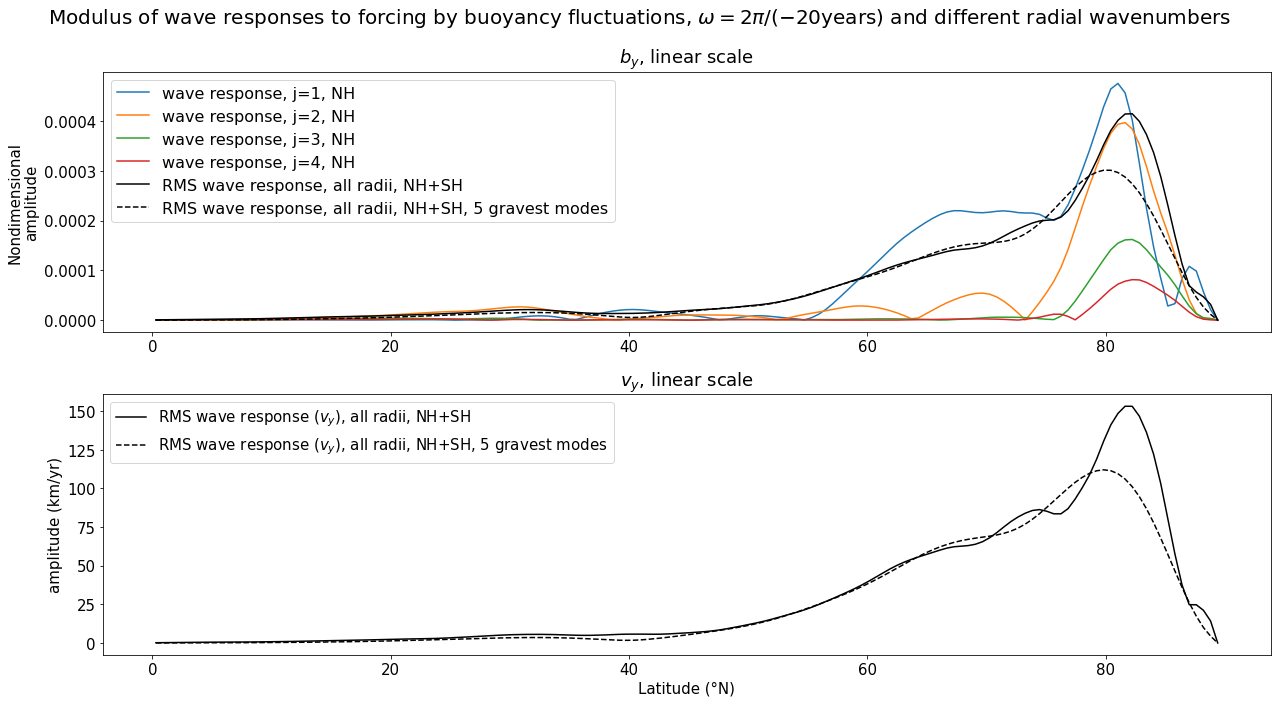

In [9]:
fig,(ax,ax2)=plt.subplots(2,1,figsize=(18,10))

# plot per radius
for j in range(1,5):
    by=set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,freqindex,j,fixedparams)
    ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i, NH'%j)
# plot RMS by with all radii
ax.plot(np.arcsin(y)*180.0/np.pi,by_rms,color='k',label='RMS wave response, all radii, NH+SH')
ax.plot(np.arcsin(y)*180.0/np.pi,by_rms_5modes,color='k',linestyle='--',label='RMS wave response, all radii, NH+SH, 5 gravest modes')
# plot vy
ax2.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,color='k',label=r'RMS wave response ($v_y$), all radii, NH+SH')
ax2.plot(np.arcsin(y)*180.0/np.pi,vy_rms_5modes/1e3*sectoyear,color='k',linestyle='--',label=r'RMS wave response ($v_y$), all radii, NH+SH, 5 gravest modes')
## Cosmetics
ax.legend(fontsize=16);ax2.legend()

ax.set_ylabel('Nondimensional\namplitude')
ax.set_title(r'$b_y$, linear scale')
ax2.set_xlabel('Latitude (°N)')
ax2.set_ylabel('amplitude (km/yr)')
ax2.set_title(r'$v_y$, linear scale')

fig.suptitle(r"Modulus of wave responses to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$ and different radial wavenumbers",fontsize=20)
fig.tight_layout()

## Power spectrum

Here, we pick the eigenmodes of the unforced problem and express the power distribution of the response to a forcing projected on a specific mode.
e.g., let's say the modes of our problem $Ax - \omega x = 0$ are $(x_n)_{1\leq n \leq N}$. We pick one $n$, identified by its period (related to its eigenvalue $\omega_n$ by $T_n = 2\pi/\omega_n$). We write the forcing (or rather its partial fourier transform) as $F(\omega,y)$, and express it as $F(\omega,y)=\sum_n c_n(\omega) x_n(y)$.

Then, denoting $x(\omega,y)$ the response to the forced problem $Ax(\omega,y) - \omega x(\omega,y) = F(\omega,y)$, one can show $x(\omega,y)=\sum_n \dfrac{c_n(\omega)}{\omega_n-\omega} x_n(y)$. We plot below, for various $n$, the function $\omega \mapsto \left|\dfrac{c_n(\omega)}{\omega_n-\omega}\right|^2$.

One caveat in all this is that $A$ itself depends on $\omega$, through the damping factor $\chi$. We will ignore this dependence by setting $\chi$ as for $\omega = - 2\pi/\text{20 years}$.

01234

Text(0.5, 1.0, '$\\omega^2|c_k(\\omega)/(\\omega_k-\\omega)|^2$')

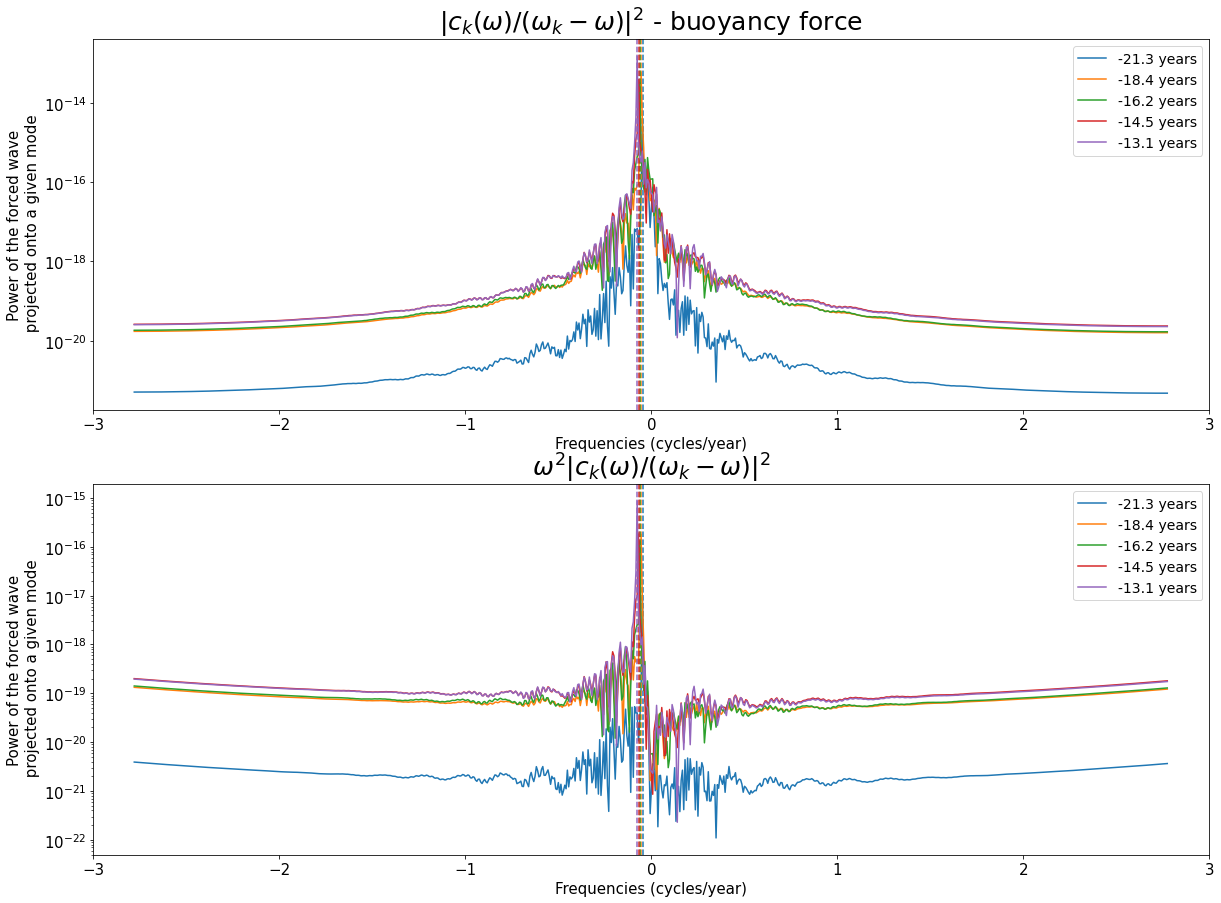

In [32]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(20,15))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    print(i,end='')
    frequencies,power_spectrum,period=spectrum_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,i,1,fixedparams,npoints=7)
    ax.plot(frequencies,power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax2.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    ax2.axvline(1/period,color=colors[i%10],linestyle='--')


for a in ax,ax2:
    a.set_xlim(-3,3) 
    a.legend(fontsize=14)
    a.set_xlabel('Frequencies (cycles/year)')
    a.set_ylabel('Power of the forced wave\n projected onto a given mode')
    a.set_yscale('log')
ax.set_title(r'$|c_k(\omega)/(\omega_k-\omega)|^2$ - buoyancy force',fontsize=25)
ax2.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)
#ax.axhline(1e-12,color='k')
#ax2.axhline(1e-14,color='k')   

Note that the tails in the acceleration spectrum are increasing (whereas the spectrum of temperature fluctuations, below, is decreasing). This is due to the fact that the RHS term in the forced equation has a term proportional to $C$, hence to $\omega$. This has an implication for the RMS value of forced waves.

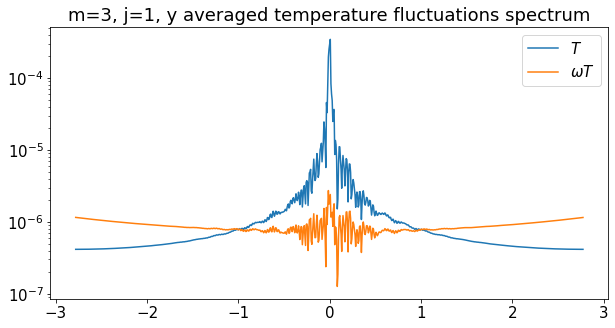

In [201]:
plt.figure(figsize=(10,5))
plt.plot(sort_freqs(frequencies),np.abs(temperature_spectrum),label=r'$T$')
plt.plot(sort_freqs(frequencies),np.abs(sort_freqs(frequencies))*np.abs(temperature_spectrum),label=r'$\omega T$')
plt.yscale('log')
plt.title('m=3, j=1, y averaged temperature fluctuations spectrum')
plt.legend()

## $b_y$ response

In [24]:
# compute forced wave; two radius is enough to capture wave power to within less than a percent
%time by_rms_buoyancy_r1_fd,vy_rms_buoyancy_r1_fd,by_powspec_buoyancy_r1_fd,by_powspec_buoyancy_r1_fd_hl = forced_waves_rms_fast("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,temperature_y_layer_tilda_150_SH,0.,0.,m,-1,1,fixedparams,300)
        

Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 21.6 s, sys: 1.34 s, total: 22.9 s
Wall time: 8.02 s


Text(0.5, 0, 'Latitude (°N)')

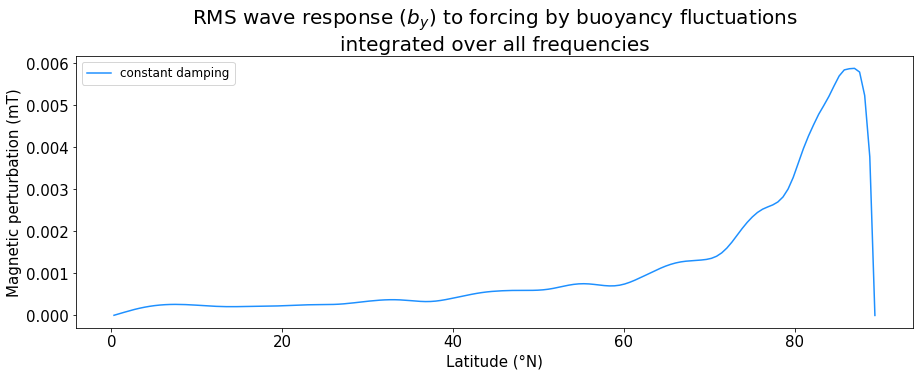

In [10]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,by_rms_buoyancy_r1_fd*1e3,color='dodgerblue',label=r'constant damping')

ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_title("RMS wave response ($b_y$) to forcing by buoyancy fluctuations\nintegrated over all frequencies",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')

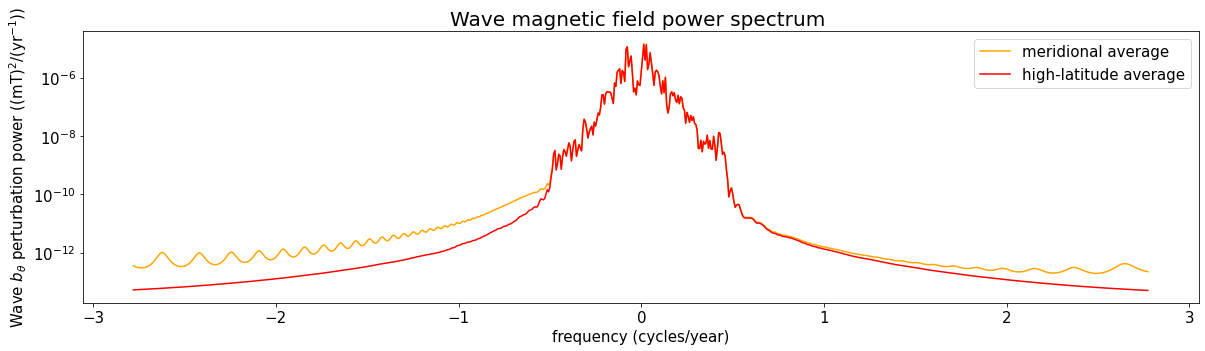

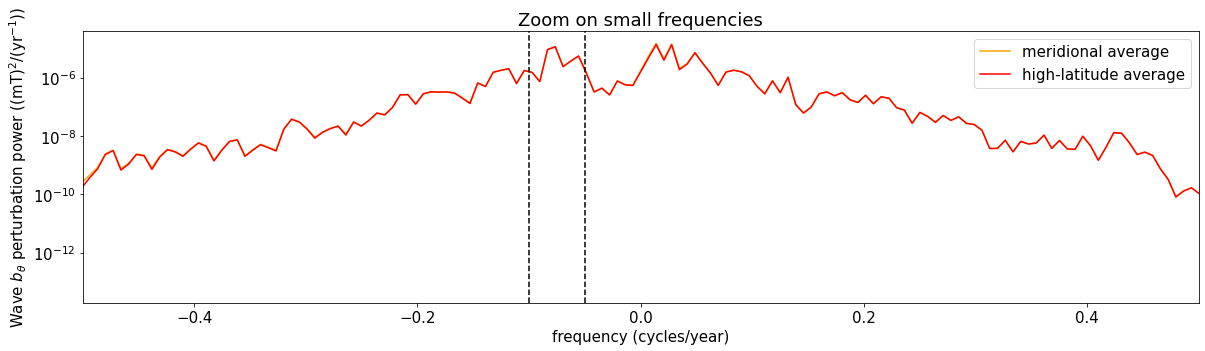

In [55]:
frequencies=nonzero_frequencies()
frequencies_sorted=np.sort(frequencies)

for _ in range(2):
    _,ax=plt.subplots(1,1,figsize=(20,5))
    
    ax.plot(frequencies_sorted   ,by_powspec_buoyancy_r1_fd[np.argsort(frequencies)]*1e3**2/sectoyear ,color='orange',label=r'meridional average')
    ax.plot(frequencies_sorted   ,by_powspec_buoyancy_r1_fd_hl[np.argsort(frequencies)]*1e3**2/sectoyear ,color='r',label=r'high-latitude average')
    
    ax.legend(fontsize=15)
    ax.set_xlabel('frequency (cycles/year)')
    ax.set_ylabel(r'Wave $b_\theta$ perturbation power ((mT)$^2$/(yr$^{-1}$))')
    ax.set_title(r"Wave magnetic field power spectrum ",fontsize=20)
    fig.tight_layout()
    ax.set_yscale('log')
ax.set_xlim(-0.5,0.5)
ax.set_title("Zoom on small frequencies")
ax.axvline(-0.1,color='k',linestyle='--')
ax.axvline(-0.05,color='k',linestyle='--')

Text(0.5, 1.0, 'count of eigenvalues of A')

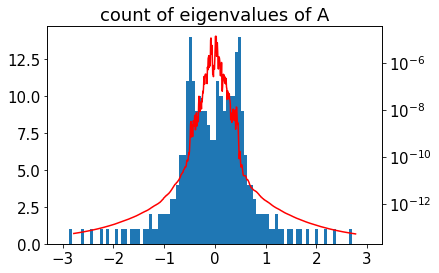

In [64]:
_,M,chi = CMchi(fixedparams,-20,1)
A = set_A(150,m,M)
wi,_,_ = compute_eigendecomp(A)
plt.hist(np.real(C_to_frequency(fixedparams,wi)),bins=np.linspace(-3,3,100))
plt.twinx()
plt.plot(frequencies_sorted   ,by_powspec_buoyancy_r1_fd_hl[np.argsort(frequencies)]*1e3**2/sectoyear ,color='r',label=r'high-latitude average')
plt.yscale('log')
plt.title("count of eigenvalues of A")

# Lorentz source

## Response to a fixed frequency

In [285]:
# Fourier transform the forcing. At this time it's still in Calypso scales
lorentz_theta_y_layer_tilda_300=transform_forcing(lorentz_theta_y,'cos')
lorentz_phi_y_layer_tilda_300  =transform_forcing(lorentz_phi_y,'cos')
lorentz_r_y_layer_tilda_300    =transform_forcing(lorentz_r_y,'cos')

In [286]:
# Convert magnitude to diffusion-free scales
E_sim=1e-5
lorentz_theta_y_layer_tilda_300*= E_sim**2
lorentz_phi_y_layer_tilda_300  *= E_sim**2
lorentz_r_y_layer_tilda_300    *= E_sim**2

In [287]:
# Extract NH and SH
lorentz_theta_y_layer_tilda_150_NH = lorentz_theta_y_layer_tilda_300[:,:,150:]
lorentz_phi_y_layer_tilda_150_NH   = lorentz_phi_y_layer_tilda_300[:,:,150:]  
lorentz_r_y_layer_tilda_150_NH     = lorentz_r_y_layer_tilda_300[:,:,150:]    

lorentz_theta_y_layer_tilda_150_SH = lorentz_theta_y_layer_tilda_300[:,:,149::-1]
lorentz_phi_y_layer_tilda_150_SH   = lorentz_phi_y_layer_tilda_300[:,:,149::-1]
lorentz_r_y_layer_tilda_150_SH     = lorentz_r_y_layer_tilda_300[:,:,149::-1]

In [288]:
freqindex=period_to_freqindex(-20)
zero=0.*lorentz_r_y_layer_tilda_150_NH
by_r_rms    ,_,_,_ = forced_waves_rms("lorentz",lorentz_r_y_layer_tilda_150_NH,zero,zero,    lorentz_r_y_layer_tilda_150_SH,zero,zero,    m,freqindex,5,fixedparams)
by_theta_rms,_,_,_ = forced_waves_rms("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,zero,lorentz_theta_y_layer_tilda_150_SH,zero,m,freqindex,5,fixedparams)
by_phi_rms  ,_,_,_ = forced_waves_rms("lorentz",zero,zero,lorentz_phi_y_layer_tilda_150_NH,  zero,zero,lorentz_phi_y_layer_tilda_150_SH,  m,freqindex,5,fixedparams)

Number of frequencies treated (1 total):  0 Number of frequencies treated (1 total):  0 Number of frequencies treated (1 total):  0 

In [336]:
freqindex=period_to_freqindex(-20)
zero=0.*lorentz_r_y_layer_tilda_150_NH
by_r_rms_5modes    ,_,_,_ = forced_waves_rms_fast("lorentz",lorentz_r_y_layer_tilda_150_NH,zero,zero,    lorentz_r_y_layer_tilda_150_SH,zero,zero,    m,freqindex,5,fixedparams,limitmodes=5)
by_theta_rms_5modes,_,_,_ = forced_waves_rms_fast("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,zero,lorentz_theta_y_layer_tilda_150_SH,zero,m,freqindex,5,fixedparams,limitmodes=5)
by_phi_rms_5modes  ,_,_,_ = forced_waves_rms_fast("lorentz",zero,zero,lorentz_phi_y_layer_tilda_150_NH,  zero,zero,lorentz_phi_y_layer_tilda_150_SH,  m,freqindex,5,fixedparams,limitmodes=5)

Number of frequencies treated (1 total):  0 Number of frequencies treated (1 total):  0 Number of frequencies treated (1 total):  0 

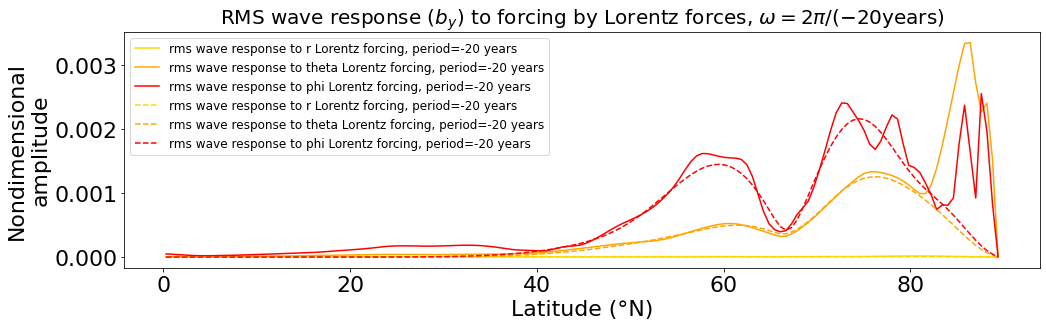

In [337]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(np.arcsin(y)*180.0/np.pi,by_r_rms,label='rms wave response to r Lorentz forcing, period=-20 years'        ,color='gold'  )
ax.plot(np.arcsin(y)*180.0/np.pi,by_theta_rms,label='rms wave response to theta Lorentz forcing, period=-20 years',color='orange')
ax.plot(np.arcsin(y)*180.0/np.pi,by_phi_rms,label='rms wave response to phi Lorentz forcing, period=-20 years'    ,color='r'     )

ax.plot(np.arcsin(y)*180.0/np.pi,by_r_rms_5modes,label='rms wave response to r Lorentz forcing, period=-20 years'        ,color='gold'  ,linestyle='--')
ax.plot(np.arcsin(y)*180.0/np.pi,by_theta_rms_5modes,label='rms wave response to theta Lorentz forcing, period=-20 years',color='orange',linestyle='--')
ax.plot(np.arcsin(y)*180.0/np.pi,by_phi_rms_5modes,label='rms wave response to phi Lorentz forcing, period=-20 years'    ,color='r'     ,linestyle='--')


ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Nondimensional\namplitude')
ax.set_title(r"RMS wave response ($b_y$) to forcing by Lorentz forces, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)

fig.tight_layout()

## Power spectrum of waves projected on distinct eigenmodes

0123456789

Text(0.5, 1.0, '$\\omega^2|c_k(\\omega)/(\\omega_k-\\omega)|^2$')

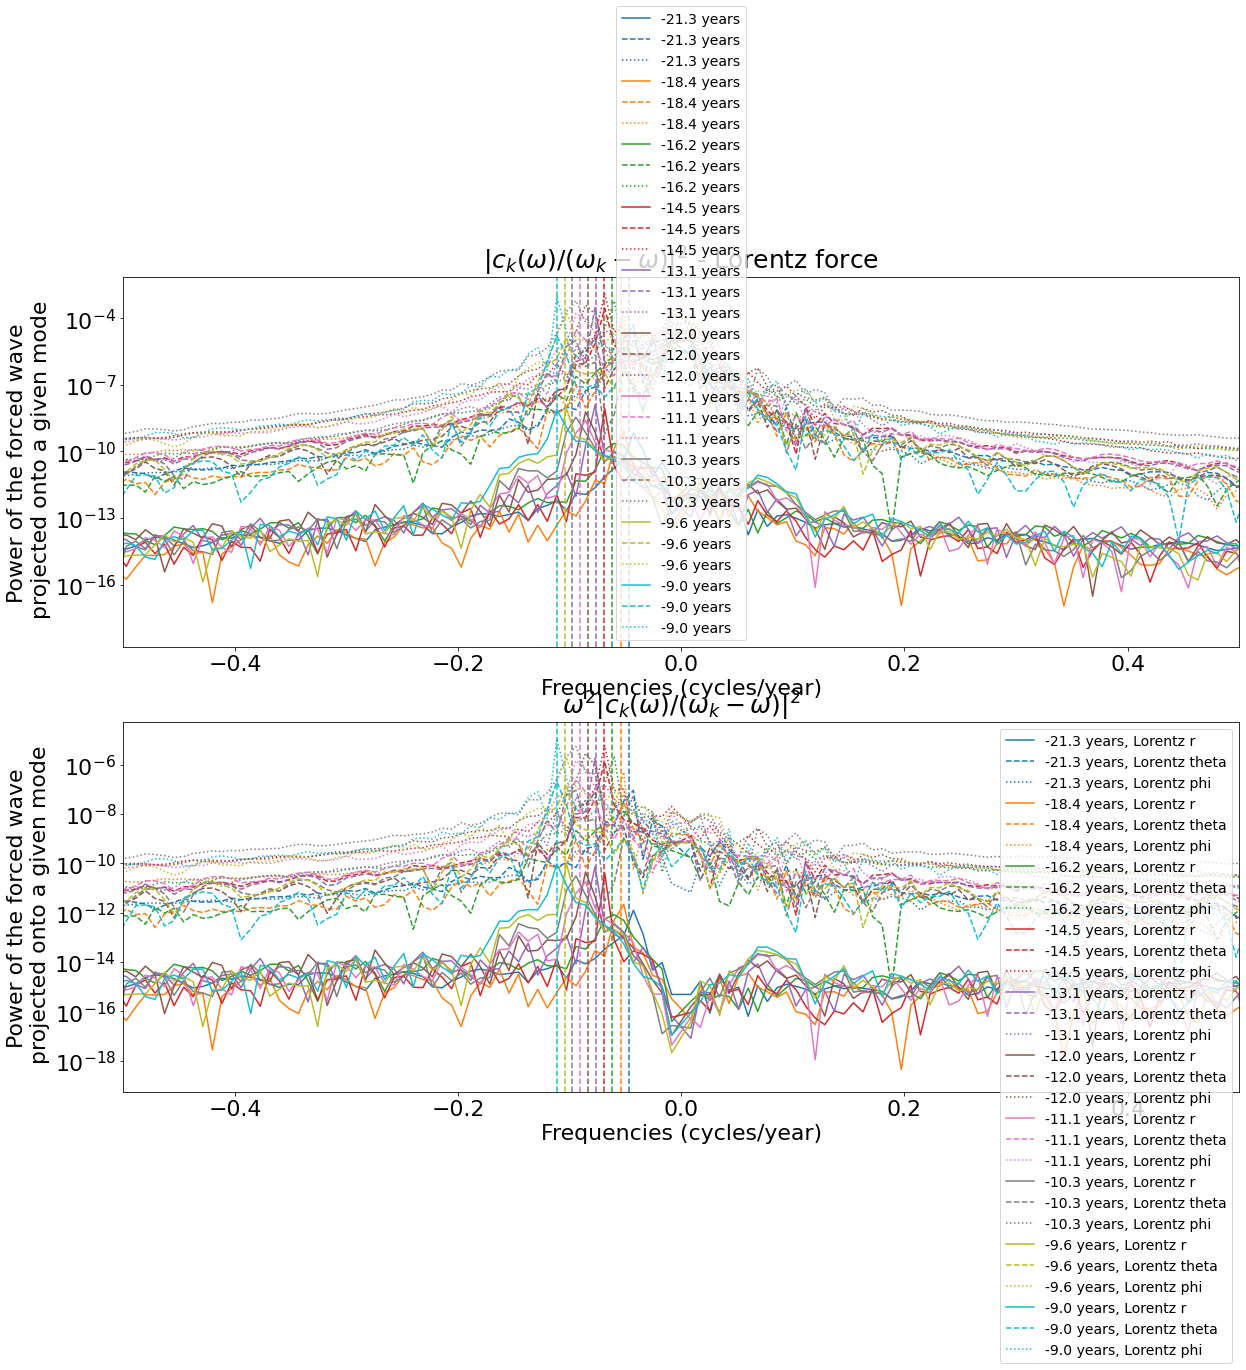

In [339]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(20,15))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    print(i,end='')
    frequencies,power_spectrum_r,period=spectrum_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_NH,zero,zero,m,i,1,fixedparams,npoints=7)
    _,power_spectrum_theta,_           =spectrum_forced_problem("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,m,i,1,fixedparams,npoints=7)
    _,power_spectrum_phi,_             =spectrum_forced_problem("lorentz",zero,zero,lorentz_phi_y_layer_tilda_150_NH,m,i,1,fixedparams,npoints=7)
    
    ax.plot(frequencies,power_spectrum_r    ,color=colors[i%10],label="%.1f years"%period,linestyle='-')
    ax.plot(frequencies,power_spectrum_theta,color=colors[i%10],label="%.1f years"%period,linestyle='--' )
    ax.plot(frequencies,power_spectrum_phi  ,color=colors[i%10],label="%.1f years"%period,linestyle=':' )
    ax2.plot(frequencies,frequencies**2*power_spectrum_r    ,color=colors[i%10],label="%.1f years, Lorentz r"%period,linestyle='-')
    ax2.plot(frequencies,frequencies**2*power_spectrum_theta,color=colors[i%10],label="%.1f years, Lorentz theta"%period,linestyle='--' )
    ax2.plot(frequencies,frequencies**2*power_spectrum_phi  ,color=colors[i%10],label="%.1f years, Lorentz phi"%period,linestyle=':' )
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    ax2.axvline(1/period,color=colors[i%10],linestyle='--')

for a in ax,ax2:
    a.set_xlim(-0.5,0.5) 
    a.legend(fontsize=14)
    a.set_xlabel('Frequencies (cycles/year)')
    a.set_ylabel('Power of the forced wave\n projected onto a given mode')
    a.set_yscale('log')
ax.set_title(r'$|c_k(\omega)/(\omega_k-\omega)|^2$ - Lorentz force',fontsize=25)
ax2.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)

    

## Response averaged over all frequencies

In [91]:
# compute forced wave; two radii are enough to capture wave power to within less than a percent (even 1 would be sufficient)
%time _,vy_rms_lorentz_r2,ay_rms_lorentz_r2,ay_byfreq_lorentz_r2 = forced_waves_rms("lorentz",lorentz_r_y_layer_tilda_150_NH,lorentz_theta_y_layer_tilda_150_NH,lorentz_phi_y_layer_tilda_150_NH,lorentz_r_y_layer_tilda_150_SH,lorentz_theta_y_layer_tilda_150_SH,lorentz_phi_y_layer_tilda_150_SH,m,-1,2,fixedparams)
    

Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 1min 3s, sys: 5.9 s, total: 1min 8s
Wall time: 37.4 s


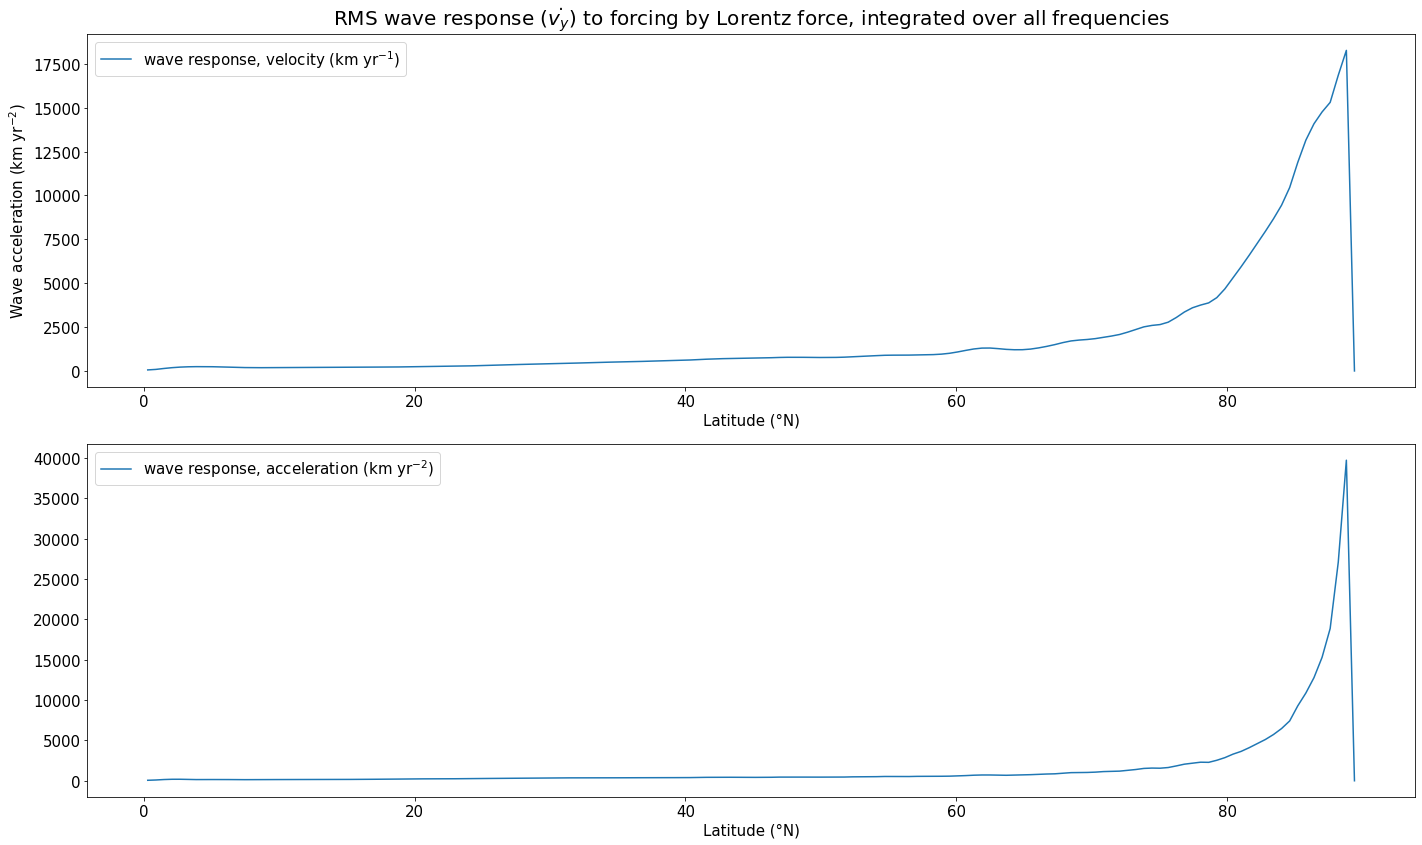

In [97]:
fig,(ax,ax2)=plt.subplots(2,1,figsize=(20,12))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms_lorentz_r2/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax2.plot(np.arcsin(y)*180.0/np.pi,ay_rms_lorentz_r2/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')


ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by Lorentz force, integrated over all frequencies",fontsize=20)
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by Lorentz force, integrated over all frequencies",fontsize=20)
for a in ax,ax2:
    a.legend()
    a.set_xlabel('Latitude (°N)')
fig.tight_layout()

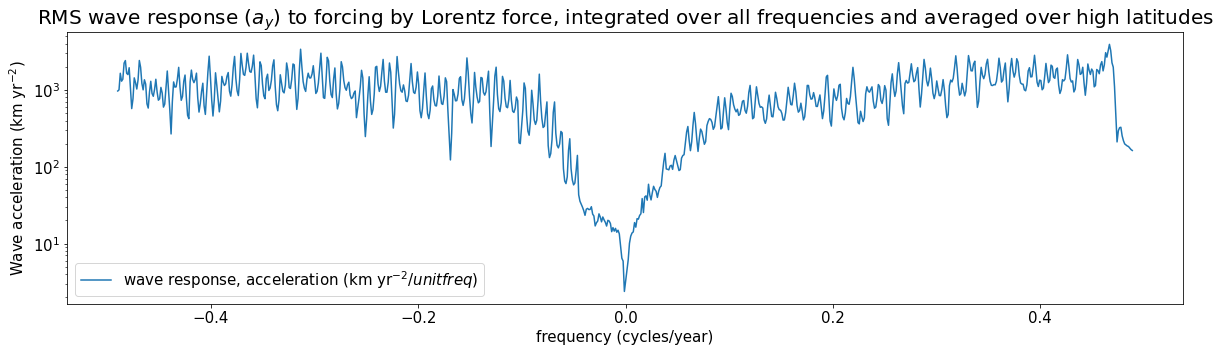

In [98]:
frequencies=nonzero_frequencies()
frequencies_sorted=np.sort(frequencies)
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(frequencies_sorted,ay_byfreq_lorentz_r2[np.argsort(frequencies)]/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by Lorentz force, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

## Amplitude, projected on eigenmodes

In [101]:
# compute forced wave; two radii are enough to capture wave power to within less than a percent (even 1 would be sufficient)
%time _,vy_rms_lorentz_r1_10modes,ay_rms_lorentz_r1_10modes,ay_byfreq_lorentz_r1_10modes = forced_waves_rms("lorentz",lorentz_r_y_layer_tilda_150_NH,lorentz_theta_y_layer_tilda_150_NH,lorentz_phi_y_layer_tilda_150_NH,lorentz_r_y_layer_tilda_150_SH,lorentz_theta_y_layer_tilda_150_SH,lorentz_phi_y_layer_tilda_150_SH,m,-1,1,fixedparams,limitmodes=10)
    

Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 16min, sys: 1min 8s, total: 17min 9s
Wall time: 8min 15s


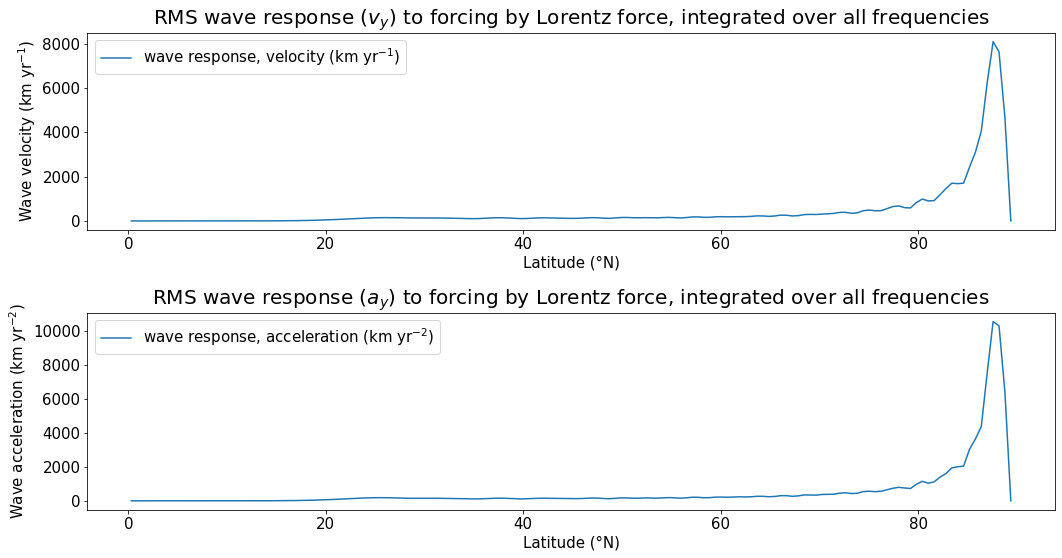

In [102]:
fig,(ax,ax2)=plt.subplots(2,1,figsize=(15,8))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms_lorentz_r1_10modes/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax2.plot(np.arcsin(y)*180.0/np.pi,ay_rms_lorentz_r1_10modes/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')


ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by Lorentz force, integrated over all frequencies",fontsize=20)
ax2.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax2.set_title(r"RMS wave response ($a_y$) to forcing by Lorentz force, integrated over all frequencies",fontsize=20)
for a in ax,ax2:
    a.legend()
    a.set_xlabel('Latitude (°N)')
fig.tight_layout()

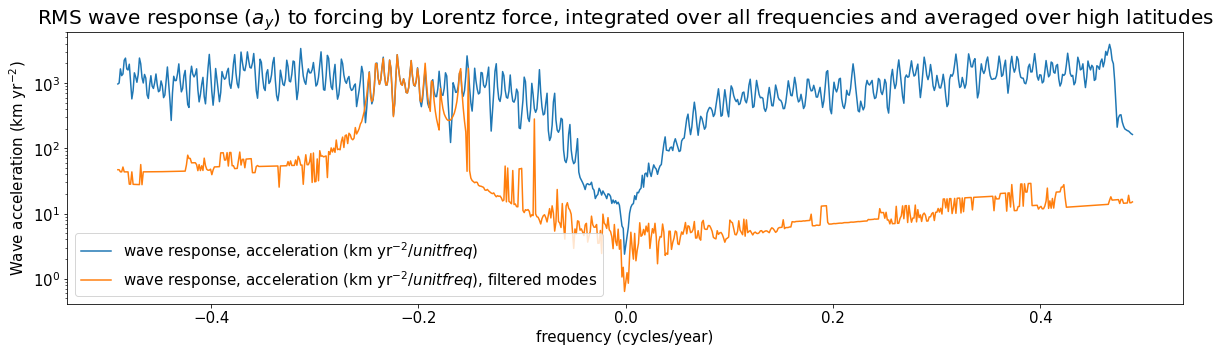

In [103]:
frequencies=nonzero_frequencies()
frequencies_sorted=np.sort(frequencies)
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(frequencies_sorted,ay_byfreq_lorentz_r2[np.argsort(frequencies)]/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.plot(frequencies_sorted,ay_byfreq_lorentz_r1_10modes[np.argsort(frequencies)]/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$), filtered modes')

ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by Lorentz force, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

# Induction source

In [106]:
# Fourier transform the forcing. At this time it's still in Calypso scales
B_theta_y_layer_tilda_300=transform_forcing(B_theta_y,'sin')
B_phi_y_layer_tilda_300  =transform_forcing(B_phi_y,'sin')

In [107]:
# Convert magnitude to diffusion-free scales
E_sim=1e-5
Pm_sim=0.5
B_theta_y_layer_tilda_300*= np.sqrt(E_sim/Pm_sim)
B_phi_y_layer_tilda_300  *= np.sqrt(E_sim/Pm_sim)

In [108]:
# Extract NH and SH
B_theta_y_layer_tilda_150_NH = B_theta_y_layer_tilda_300[:,:,150:]
B_phi_y_layer_tilda_150_NH   = B_phi_y_layer_tilda_300[:,:,150:]  

B_theta_y_layer_tilda_150_SH = B_theta_y_layer_tilda_300[:,:,149::-1]
B_phi_y_layer_tilda_150_SH   = B_phi_y_layer_tilda_300[:,:,149::-1]

## Response to a fixed frequency

758


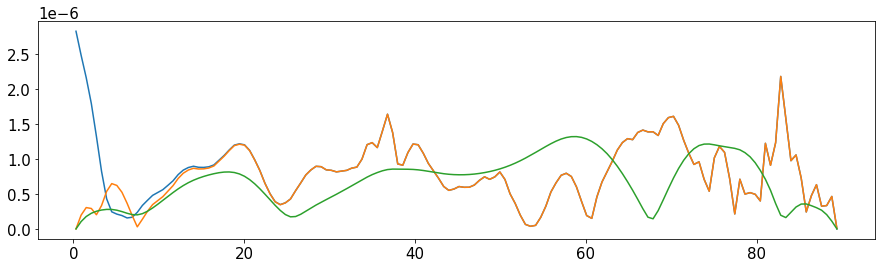

In [178]:
freqindex=period_to_freqindex(-20)
print(freqindex)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test=set_solve_forced_problem("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams)
test_gev=set_solve_forced_problem_gev("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams,OPT=1)
test_gev2=set_solve_forced_problem_gev("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams,OPT=2)

ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test),label="Classic formulation")
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test_gev),label="Generalized eigenvalue problem formulation")
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test_gev2),label="Generalized eigenvalue problem formulation, without the second derivative term")
fig.suptitle(r"Modulus of wave response to forcing by induction, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
ax.legend()

CPU times: user 1.79 s, sys: 171 ms, total: 1.96 s
Wall time: 3.51 s


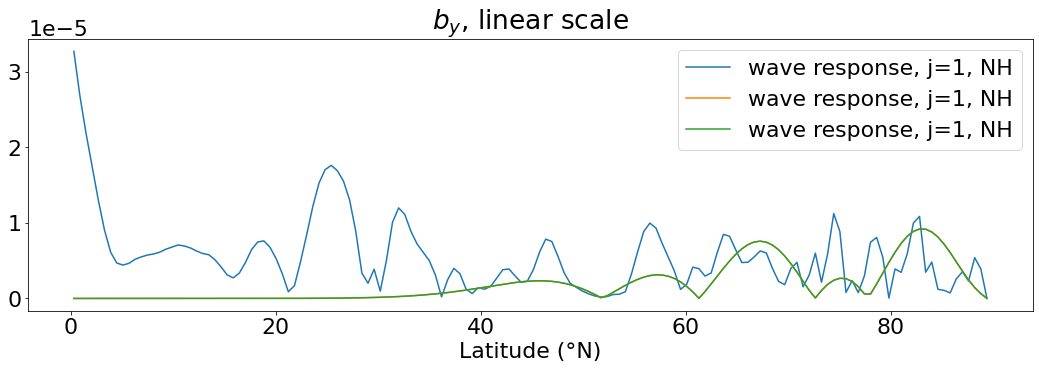

In [110]:
%%time
fig,ax=plt.subplots(1,1,figsize=(18,5))
y=set_y(150)
freqindex=period_to_freqindex(-20)
zero=0.*lorentz_r_y_layer_tilda_150_NH

# plot per radius
j=1
by=set_solve_forced_problem("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,j,fixedparams)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i, NH'%j)

by=set_solve_forced_problem("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,j,fixedparams,limitmodes=5)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i, NH'%j)

by=set_solve_forced_problem_gev("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,j,fixedparams,limitmodes=5)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i, NH'%j)

# plot RMS by with all radii
ax.set_title(r'$b_y$, linear scale')
ax.set_xlabel('Latitude (°N)')
ax.legend()

751


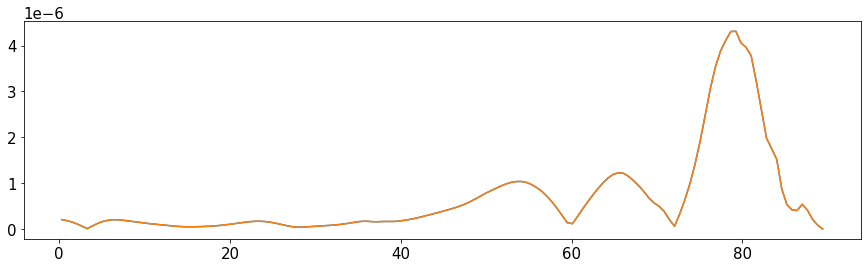

In [162]:
freqindex=period_to_freqindex(-17)
print(freqindex)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test=set_solve_forced_problem("induction",zero,zero,B_phi_y_layer_tilda_150_NH,m,freqindex,1,fixedparams)
test_gev=set_solve_forced_problem("induction",zero,zero,B_phi_y_layer_tilda_150_NH,m,freqindex,1,fixedparams)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test_gev))

## Response averaged over all frequencies

In [110]:
# compute forced wave; two radii are enough to capture wave power to within less than a percent (even 1 would be sufficient)
zero=B_theta_y_layer_tilda_150_NH
%time _,vy_rms_induction_r2,ay_rms_induction_r2,ay_byfreq_induction_r2 = forced_waves_rms("induction",zero,B_theta_y_layer_tilda_150_NH,B_phi_y_layer_tilda_150_NH,zero,B_theta_y_layer_tilda_150_SH,B_phi_y_layer_tilda_150_SH,m,-1,2,fixedparams)
    

Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 1min 34s, sys: 5.98 s, total: 1min 40s
Wall time: 33.7 s


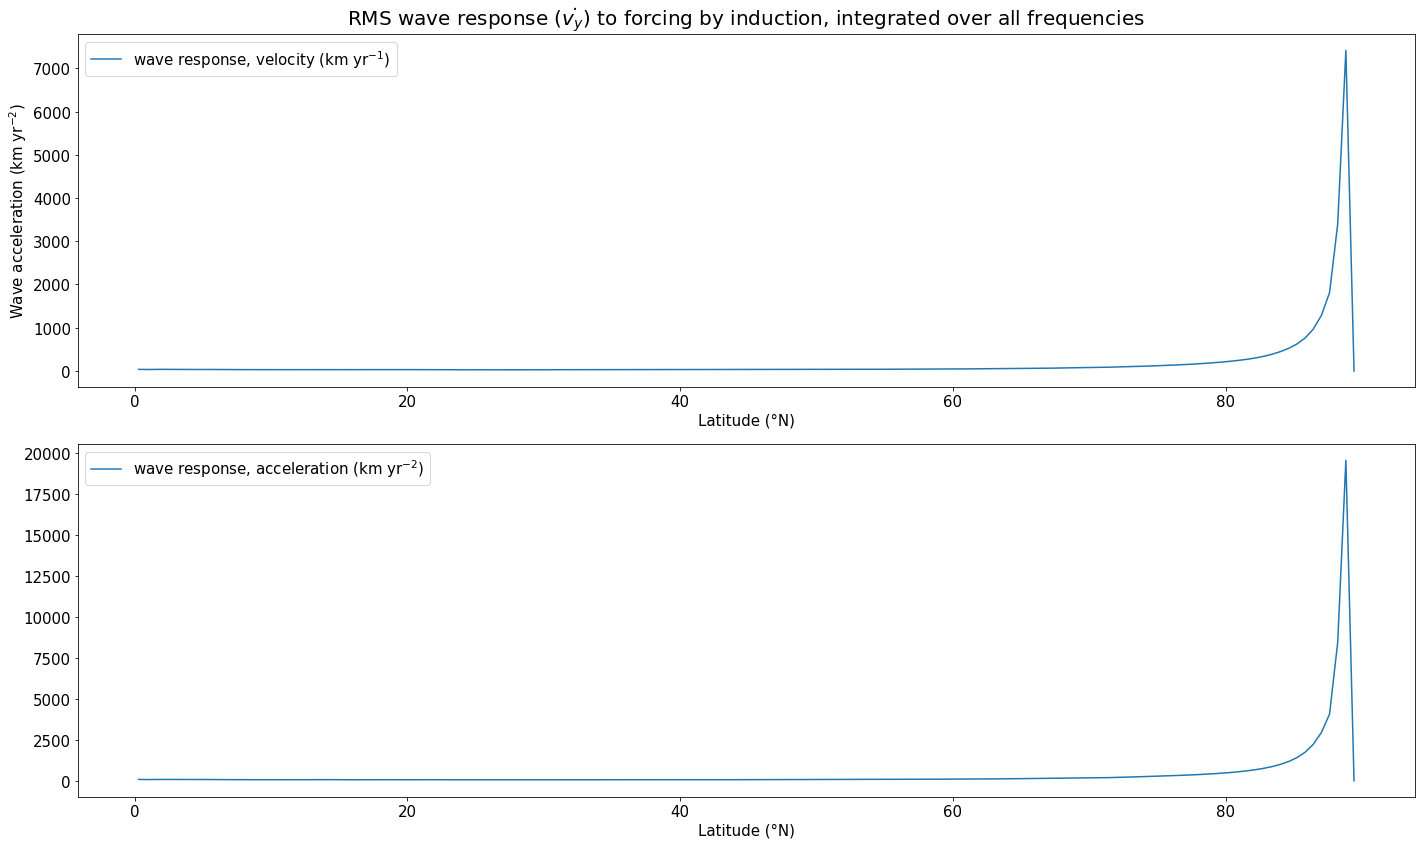

In [111]:
fig,(ax,ax2)=plt.subplots(2,1,figsize=(20,12))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms_induction_r2/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax2.plot(np.arcsin(y)*180.0/np.pi,ay_rms_induction_r2/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')


ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by induction, integrated over all frequencies",fontsize=20)
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by induction, integrated over all frequencies",fontsize=20)
for a in ax,ax2:
    a.legend()
    a.set_xlabel('Latitude (°N)')
fig.tight_layout()

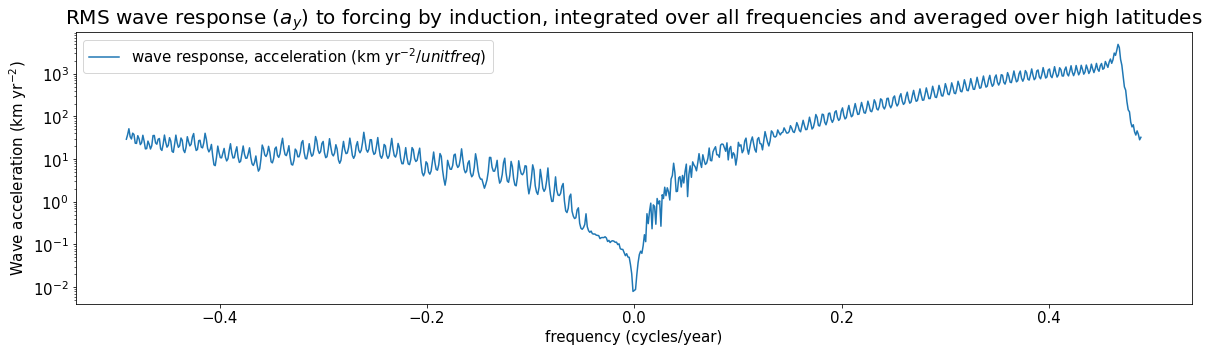

In [112]:
frequencies=nonzero_frequencies()
frequencies_sorted=np.sort(frequencies)
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(frequencies_sorted,ay_byfreq_induction_r2[np.argsort(frequencies)]/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by induction, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

## Amplitude, projected on eigenmodes

In [120]:
# compute forced wave; two radii are enough to capture wave power to within less than a percent (even 1 would be sufficient)
%time _,vy_rms_induction_r1_8modes,ay_rms_induction_r1_8modes,ay_byfreq_induction_r1_8modes = forced_waves_rms("induction",zero,B_theta_y_layer_tilda_150_NH,B_phi_y_layer_tilda_150_NH,zero,B_theta_y_layer_tilda_150_SH,B_phi_y_layer_tilda_150_SH,m,-1,1,fixedparams,limitmodes=8,gev=True)
    

Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 44min 38s, sys: 1min 50s, total: 46min 28s
Wall time: 9h 40min 57s


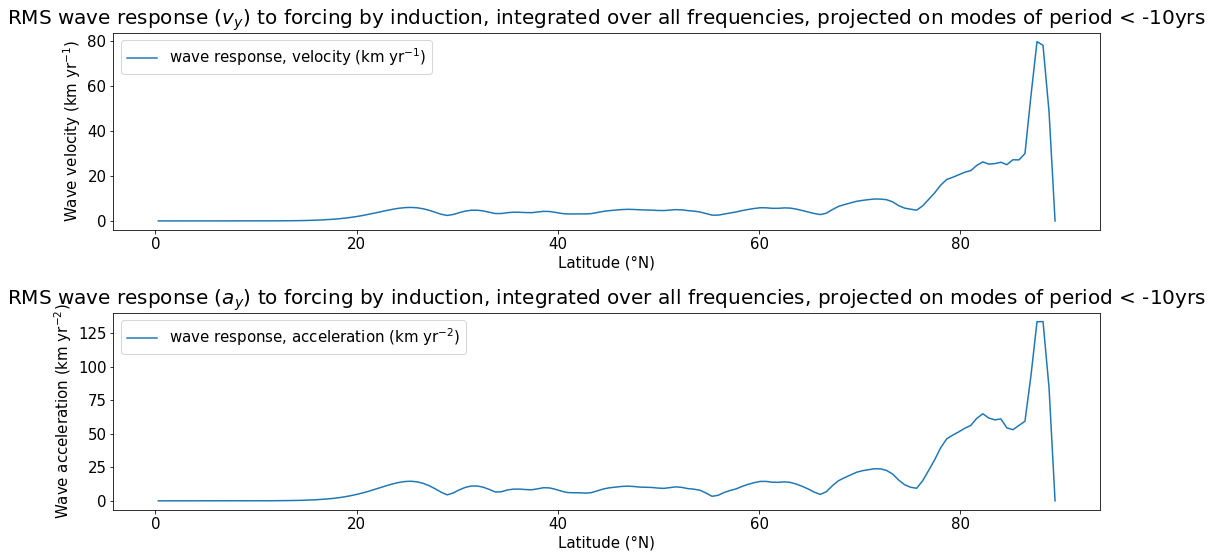

In [124]:
fig,(ax,ax2)=plt.subplots(2,1,figsize=(15,8))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms_induction_r1_8modes/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax2.plot(np.arcsin(y)*180.0/np.pi,ay_rms_induction_r1_8modes/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')


ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by induction, integrated over all frequencies, projected on modes of period < -10yrs",fontsize=20)
ax2.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax2.set_title(r"RMS wave response ($a_y$) to forcing by induction, integrated over all frequencies, projected on modes of period < -10yrs",fontsize=20)
for a in ax,ax2:
    a.legend()
    a.set_xlabel('Latitude (°N)')
fig.tight_layout()

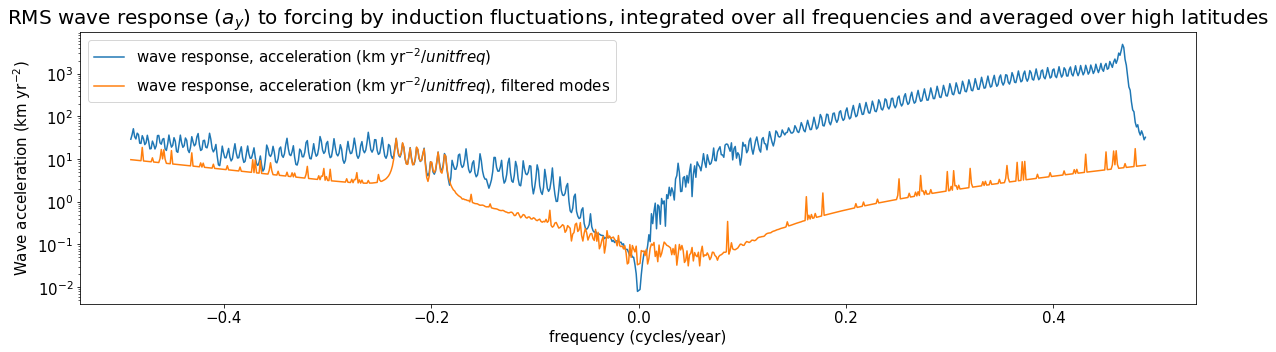

In [125]:
frequencies=nonzero_frequencies()
frequencies_sorted=np.sort(frequencies)
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(frequencies_sorted,ay_byfreq_induction_r2[np.argsort(frequencies)]/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.plot(frequencies_sorted,ay_byfreq_induction_r1_8modes[np.argsort(frequencies)]/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$), filtered modes')

ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by induction fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

# Paper figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


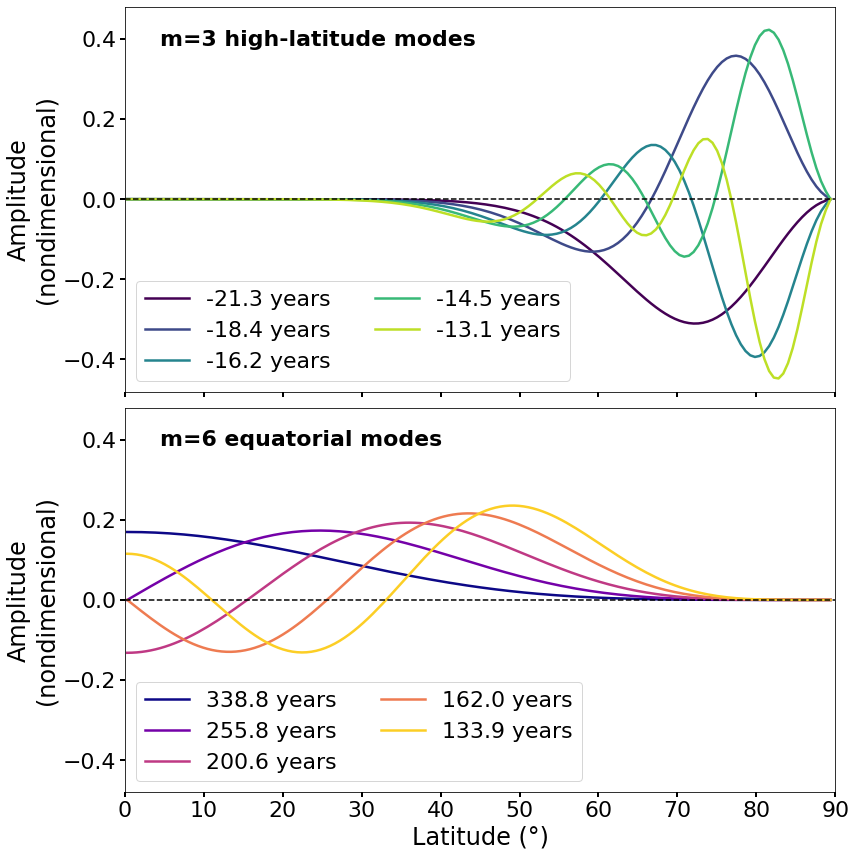

In [208]:
# Plotting the first few high-lat and equatorial eigenmodes
def plot_eigenmodes(ax,n1,n2,westward_traveling=True,m=3,colors=1,loc=2):
    ngrid=150

    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition, with dirichlet BC
    y=set_y(ngrid)
    A = set_A(ngrid,m,M,option=1)
    wi,xi=spl.eig(A)
    if not westward_traveling: # Add Neumann BC solutions as well
        A = set_A(ngrid,m,M,option=2)
        wi_n,xi_n=spl.eig(A)
        wi=np.concatenate([wi,wi_n])
        xi=np.concatenate([xi,xi_n],axis=1)
    #Merge all eigenvalues and eigenvectors; and sort them by increasing period
    if westward_traveling:
        order=np.argsort(np.real(1/wi))
    else:
        order=np.argsort(-np.real(1/wi))
        xi*=np.sign(xi[len(y)-10])
    xi=xi[:len(y),order]/(1-y[:,None]**2)
    wi=wi[order]
    
    lns='-'
    lw=2.5
    if colors==1:
        clrs=plt.cm.viridis(np.linspace(0,0.9,n2-n1))
    elif colors==2:
        clrs=plt.cm.plasma(np.linspace(0,0.9,n2-n1))
    
    for i in range(n1,n2):
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label="%.1f years"%eigenmode_period,linestyle=lns,linewidth=lw,color=clrs[i-n1])

    ax.set_xlim(0,90)
    ax.legend(loc=loc,ncol=2)#,fontsize=20,borderpad=0.3,labelspacing=0.4,borderaxespad=0.3)
    ax.set_ylim(-0.48,0.48)
    ax.set_ylabel("Amplitude\n(nondimensional)",fontsize=24)
    ax.axhline(0.,linestyle='--',color='k')
    ax.tick_params(width=2,length=5)
    


matplotlib.rcParams.update({'font.size':22})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(12,12))
plot_eigenmodes(ax ,0,5,westward_traveling=True ,m=3,colors=1,loc=3)
plot_eigenmodes(ax2,0,5,westward_traveling=False,m=6,colors=2,loc=3)
ax2.set_xlabel("Latitude (°)",fontsize=24)
ax.set_xticks(range(0,100,10))
ax.set_xticklabels([""]*10)
xt=0.05;yt=0.9
ax.text( xt,yt, 'm=3 high-latitude modes',fontweight='bold', transform=ax.transAxes)
ax2.text(xt,yt, 'm=6 equatorial modes'   ,fontweight='bold', transform=ax2.transAxes)
fig.tight_layout(pad=0.5)
fig.savefig('/Users/quentin.nicolas/Downloads/modes.eps', format='eps',bbox_inches='tight')

westward-traveling power : 9.51e-11
eastward-traveling power : 9.20e-11


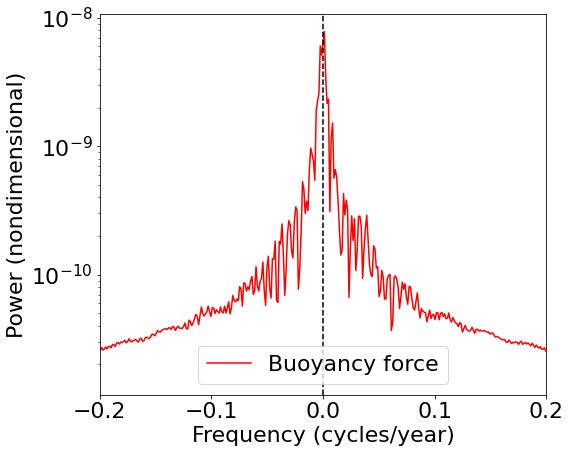

In [72]:
# Power spectra and rms sources

def plot_spectrum_source(ax,forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,fixedparams,lbl,clr,lns='-',print_pwr=False):    
    # adapts chi
    nt,_,ngrid=forcingtilda_r.shape
    y=set_y(ngrid//2,two_sides=True)
    #y=set_y(ngrid)
    
    freqs = nonzero_frequencies() # all frequencies in years^-1
    Fr = 1j*np.zeros((nt,ngrid))
    Ftheta,Fphi=np.copy(Fr),np.copy(Fr)
    # Compute forcings
    if forcing_name == "buoyancy":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_buoyancy_forcing(forcingtilda_r,freqindex,1,fixedparams)
    elif forcing_name == "lorentz":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,1,fixedparams)
    Fr_yavg = np.trapz(Fr,y,axis=1)
    Ftheta_yavg = np.trapz(Ftheta,y,axis=1)
    Fphi_yavg = np.trapz(Fphi,y,axis=1)
    permut = np.roll(np.arange(nt),(nt+1)//2)
    ax.plot(freqs[permut],np.abs(Fr_yavg+Ftheta_yavg+Fphi_yavg)[permut],label=lbl,color=clr,linestyle=lns)
    #ax.plot(-freqs[permut],np.abs(Fr_yavg)[permut])
    if print_pwr:
        print("westward-traveling power : %.2e"%(np.abs(Fr_yavg+Ftheta_yavg+Fphi_yavg)[permut][:nt//2+1].mean()))
        print("eastward-traveling power : %.2e"%(np.abs(Fr_yavg+Ftheta_yavg+Fphi_yavg)[permut][nt//2+1:].mean()))
    ax.set_yscale('log')
    ax.set_xlabel('Frequency (cycles/year)')
    ax.set_xlim(-0.2,0.2)
    ax.set_ylabel('Power (nondimensional)')
    ax.axvline(0.,color='k',linestyle='--')
    ax.legend()

matplotlib.rcParams.update({'font.size':22})
fig,ax=plt.subplots(1,1,figsize=(8,7))
plot_spectrum_source(ax,"buoyancy",temperature_y_layer_tilda_300,0.,0.,fixedparams,"Buoyancy force",'red',print_pwr=True)


westward-traveling power : 1.34e-08
eastward-traveling power : 1.52e-08
westward-traveling power : 1.46e-06
eastward-traveling power : 1.49e-06
westward-traveling power : 8.71e-07
eastward-traveling power : 9.78e-07


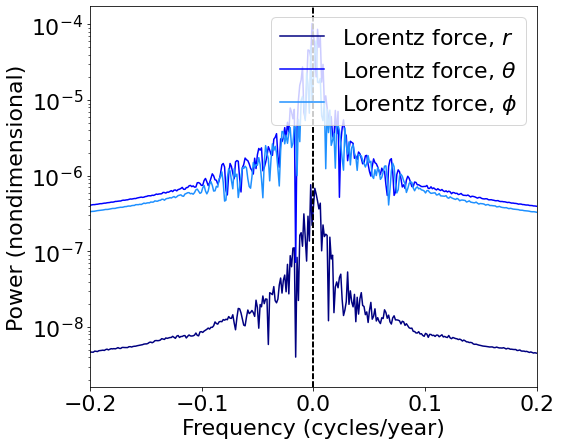

In [73]:
matplotlib.rcParams.update({'font.size':22})
fig,ax=plt.subplots(1,1,figsize=(8,7))
plot_spectrum_source(ax,"lorentz",lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300   ,fixedparams,r"Lorentz force, $r$"     ,'navy'      ,print_pwr=True)
plot_spectrum_source(ax,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_theta_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,fixedparams,r"Lorentz force, $\theta$",'blue'      ,print_pwr=True)
plot_spectrum_source(ax,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_phi_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300  ,fixedparams,r"Lorentz force, $\phi$"  ,'dodgerblue',print_pwr=True)


In [84]:
# Power spectra and rms sources

def plot_rms_source(ax,forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,fixedparams,lbl,clr,lns='-'):    
    # adapts chi
    nt,_,ngrid=forcingtilda_r.shape
    ngrid=ngrid//2
    y=set_y(ngrid)

    Fr = 1j*np.zeros((nt,2*ngrid))
    Ftheta,Fphi=np.copy(Fr),np.copy(Fr)
    # Compute forcings
    if forcing_name == "buoyancy":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_buoyancy_forcing(forcingtilda_r,freqindex,1,fixedparams)
    elif forcing_name == "lorentz":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,1,fixedparams)
    Fr_rms=0.5*(np.sqrt( 0.5*(np.abs(Fr[:,ngrid:])**2).sum(axis=0))
               +np.sqrt( 0.5*(np.abs(Fr[:,:ngrid][::-1])**2).sum(axis=0))
               )
    Ftheta_rms=0.5*(np.sqrt( 0.5*(np.abs(Ftheta[:,ngrid:])**2).sum(axis=0))
                   +np.sqrt( 0.5*(np.abs(Ftheta[:,:ngrid][::-1])**2).sum(axis=0))
           )
    Fphi_rms=0.5*(np.sqrt( 0.5*(np.abs(Fphi[:,ngrid:])**2).sum(axis=0))
                 +np.sqrt( 0.5*(np.abs(Fphi[:,:ngrid][::-1])**2).sum(axis=0))
           )    

    ax.plot(np.arcsin(y)*180.0/np.pi,Fr_rms+Ftheta_rms+Fphi_rms,label=lbl,color=clr,linestyle=lns,linewidth=2)
    #ax.set_yscale('log')
    ax.set_xlabel('Latitude (°)')
    ax.set_xlim(0.,90)
    ax.set_ylabel('RMS amplitude (nondimensional)')
    #ax.set_ylim(0.,1.1*np.max(Fr_rms+Ftheta_rms+Fphi_rms))
    #ax.axvline(0.,color='k',linestyle='--')
    ax.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


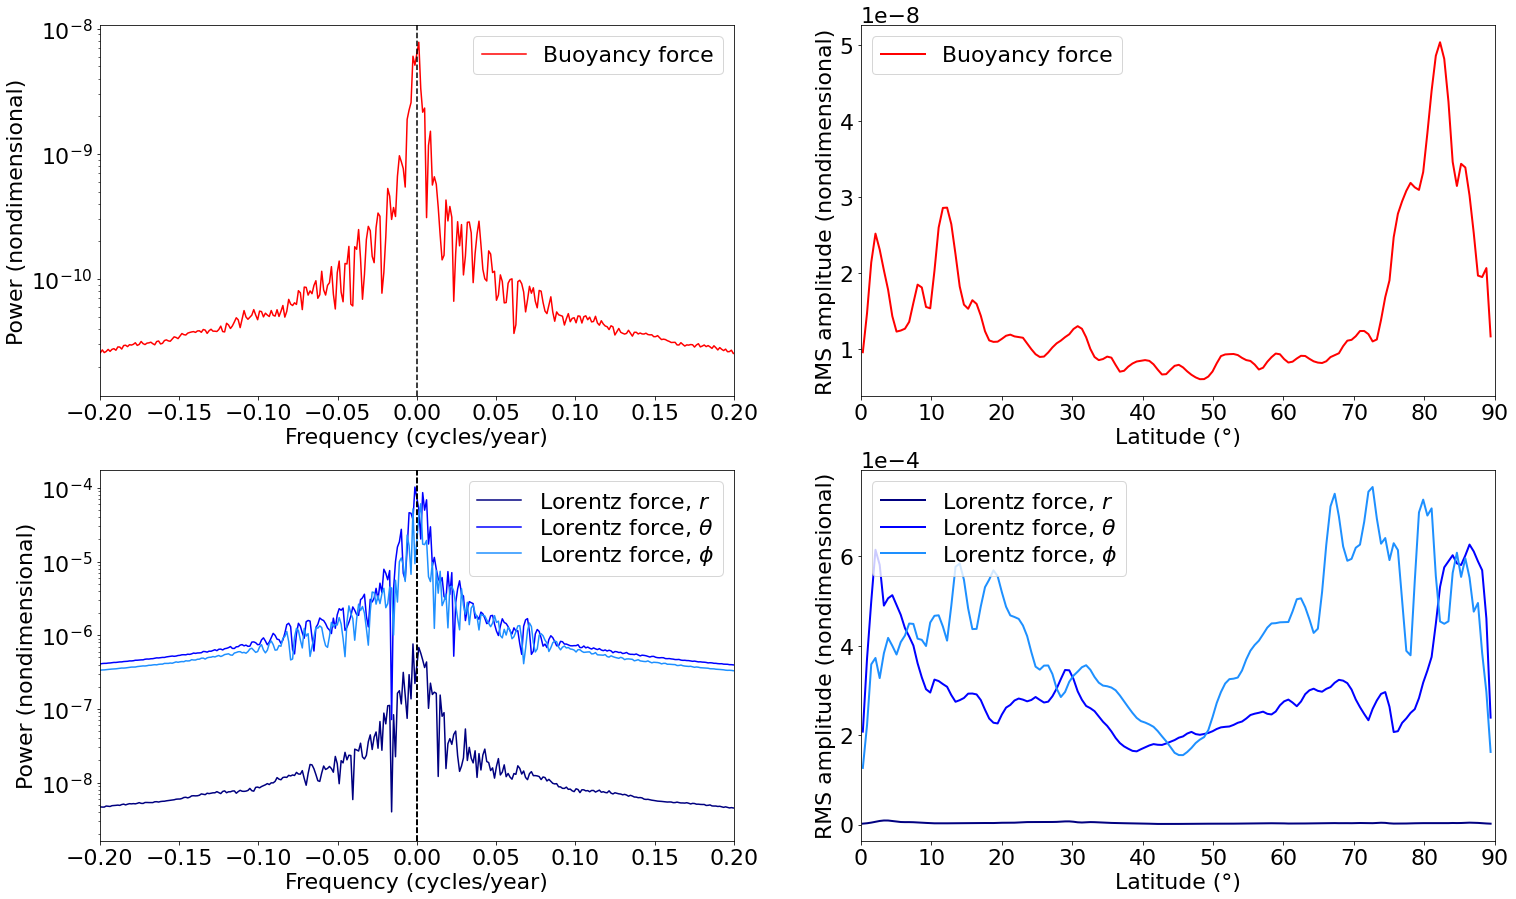

In [85]:
matplotlib.rcParams.update({'font.size':22})
fig = plt.figure(figsize=(25,15))
spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios= [3,3],figure=fig)
axb1  = fig.add_subplot(spec[0,0])
axb2  = fig.add_subplot(spec[0,1])
axl1  = fig.add_subplot(spec[1,0])
axl2  = fig.add_subplot(spec[1,1])

plot_spectrum_source(axb1,"buoyancy",temperature_y_layer_tilda_300,0.,0.,fixedparams,"Buoyancy force",'red')

plot_rms_source(axb2,"buoyancy",temperature_y_layer_tilda_300,0.,0.,fixedparams,"Buoyancy force",'red')

plot_spectrum_source(axl1,"lorentz",lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300   ,fixedparams,r"Lorentz force, $r$"     ,clr='navy')
plot_spectrum_source(axl1,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_theta_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,fixedparams,r"Lorentz force, $\theta$",clr='blue')
plot_spectrum_source(axl1,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_phi_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300  ,fixedparams,r"Lorentz force, $\phi$"  ,clr='dodgerblue')

plot_rms_source(axl2,"lorentz",lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300   ,fixedparams,r"Lorentz force, $r$"     ,clr='navy')
plot_rms_source(axl2,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_theta_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,fixedparams,r"Lorentz force, $\theta$",clr='blue')
plot_rms_source(axl2,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_phi_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300  ,fixedparams,r"Lorentz force, $\phi$"  ,clr='dodgerblue')

axl1.legend(loc=1,labelspacing=0.2)
axl2.legend(loc=2,labelspacing=0.2)
axl2.ticklabel_format(scilimits=(-2,2))
fig.savefig('/Users/quentin.nicolas/Downloads/sources.eps', format='eps',bbox_inches='tight')

# Modes with GEV

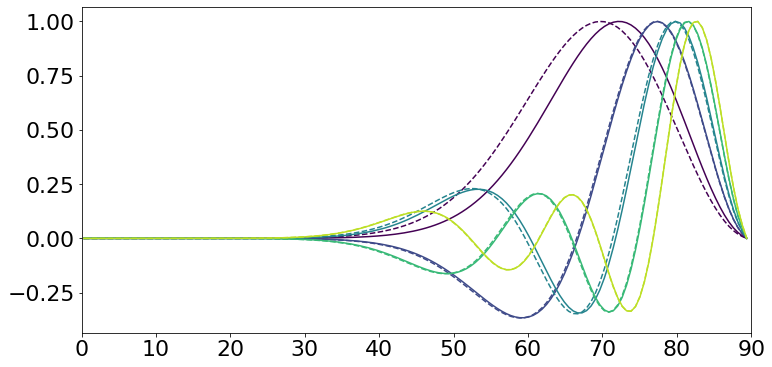

In [78]:
# Plotting the first few high-lat and equatorial eigenmodes
def plot_eigenmode(ax,n1,n2,m=3):
    ngrid=150

    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition, with dirichlet BC
    y=set_y(ngrid)
    A = set_A(ngrid,m,M,option=1)
    wi,xi=spl.eig(A)
    order=np.argsort(np.real(1/wi))
    xi=xi[:len(y),order]/(1-y[:,None]**2)
    wi=wi[order]
    
    Ag,Bg = set_AB(ngrid,m,M)
    wig,xig=spl.eig(Ag,Bg,left=False)
    order=np.argsort(np.real(1/wig))
    xig=xig[:len(y),order]/(1-y[:,None]**2)
    wig=wig[order]
    
    clrs=plt.cm.viridis(np.linspace(0,0.9,n2-n1))
    for i in range(n1,n2):
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        argmax = np.argmax(np.abs(np.real(xi[:,i])))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i])/np.real(xi[argmax,i]),label="%.1f years"%eigenmode_period,color=clrs[i])
        
        eigenmode_period = np.real(2*np.pi*C0/(wig[i]*sectoyear*Omega))
        argmax = np.argmax(np.abs(np.real(xig[:,i])))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xig[:,i])/np.real(xig[argmax,i]),label="%.1f years"%eigenmode_period,linestyle='--',color=clrs[i])

    ax.set_xlim(0,90)
    


matplotlib.rcParams.update({'font.size':22})
fig,ax=plt.subplots(1,1,figsize=(12,6))
plot_eigenmode(ax ,0,5,m=3)

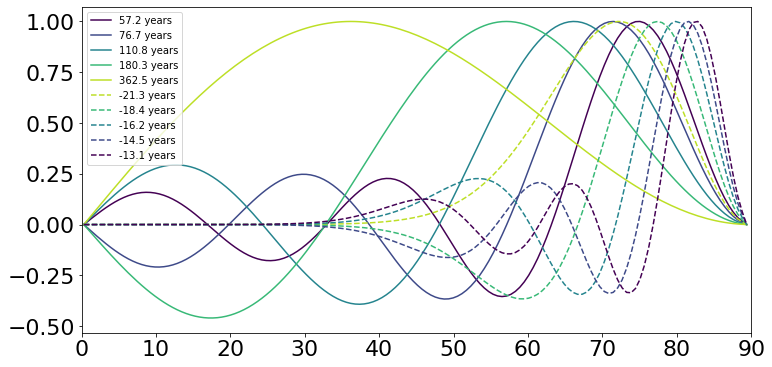

In [211]:
# Plotting the first few high-lat and equatorial eigenmodes
def plot_eigenmode(ax,n1,n2,m=3):
    ngrid=150

    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition, with dirichlet BC
    y=set_y(ngrid)
    A = set_A(ngrid,m,M,option=1)
    wi,xi=spl.eig(A)
    order=np.argsort(np.real(1/wi))
    xi=xi[:len(y),order]/(1-y[:,None]**2)
    wi=wi[order]
    
    clrs=plt.cm.viridis(np.linspace(0,0.9,n2-n1))
    for i in range(n1,n2):
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        argmax = np.argmax(np.abs(np.real(xi[:,i])))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i])/np.real(xi[argmax,i]),label="%.1f years"%eigenmode_period,color=clrs[i-n1])
    n1=0;n2=5
    for i in range(n1,n2):
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        argmax = np.argmax(np.abs(np.real(xi[:,i])))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i])/np.real(xi[argmax,i]),label="%.1f years"%eigenmode_period,linestyle='--',color=clrs[n2-i-1])

    ax.set_xlim(0,90)
    ax.legend(loc=2,fontsize=10)
    


matplotlib.rcParams.update({'font.size':22})
fig,ax=plt.subplots(1,1,figsize=(12,6))
plot_eigenmode(ax ,295,300,m=3)

# Why is all the power located at high latitudes ?

## Influence of damping

In [319]:
def forced_waves_rms_2(forcingtilda_r_NH,m,jmax,fixedparams,fixA=False,syntheticRHS=False,frequencies=np.linspace(-1,1,500)):
    ones=np.ones((799, 58, 150))
    # Define freqs / radial wavenumbers
    E,Pm,_,Hprime,_,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    period = -20
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    C0 = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M0 = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Set up unforced problem
    ngrid = 150
    y = set_y(ngrid)   
    A = set_A(ngrid,m,M0)
    
    if not syntheticRHS:
        frequencies=nonzero_frequencies()
    omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

    js=np.arange(1,jmax+1); ks = np.pi/Hprime*js[None,:,None]
    
    #Compute all forced waves
    Nf=len(frequencies)
    by_all_NH=np.zeros((Nf,jmax,ngrid))*1j
    
    print("Number of frequencies treated (%i total): "%Nf,end=' ')
    for i,f in enumerate(frequencies):
        if i%20==0:
            print(i,end=' ')
        for j in js:
            period = 1/f
            kprime = np.pi*j/Hprime
            omegaprime = 2*np.pi / (period*sectoyear) / Omega
            C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
            
            chi = 1 +1j*kprime**2/omegaprime*E/Pm
            M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
            
            if not fixA:
                A = set_A(ngrid,m,M)
                
            if syntheticRHS:
                rhs = np.hstack([np.zeros(150),1-y**2])
            else:
                rhs = set_rhs_forcing(y,C,m,M,*set_buoyancy_forcing(forcingtilda_r_NH,period_to_freqindex(period),j,fixedparams))
            by_all_NH[i,j-1,:] = solve_forced_problem(y,A,C,rhs)
            
    chis = 1 +1j*ks**2/omegas_nondim*E/Pm #Size : Nf*jmax*1
    b_to_v_factor = 1j*omegas_nondim*chis/Brprime/ks
    v_to_a_factor = -1j*omegas_nondim
    L = 3.48e6*0.65
    acceleration_scale = Omega**2*L

    ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH

    y=set_y(ngrid)[None,:]
    return (frequencies,
            np.sqrt((0.5*(np.abs(ay_all_NH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1)/(1-y**2) ).sum(axis=1)),
            np.sqrt((0.5*(np.abs(by_all_NH)**2).sum(axis=1) * np.gradient(y,edge_order=2,axis=1)/(1-y**2) ).sum(axis=1)),
            np.sqrt( 0.5*(np.abs(ay_all_NH)**2).sum(axis=(0,1))),
            np.sqrt( 0.5*(np.abs(by_all_NH)**2).sum(axis=(0,1)))
           )


In [280]:
freqs,ay_byfreq_sim,by_byfreq_sim,ay_rms_sim,by_rms_sim = forced_waves_rms_2(temperature_y_layer_tilda_150_NH,m,2,fixedparams)
freqs,ay_byfreq_sim_fixA,by_byfreq_sim_fixA,ay_rms_sim_fixA,by_rms_sim_fixA = forced_waves_rms_2(temperature_y_layer_tilda_150_NH,m,2,fixedparams,fixA=True)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 

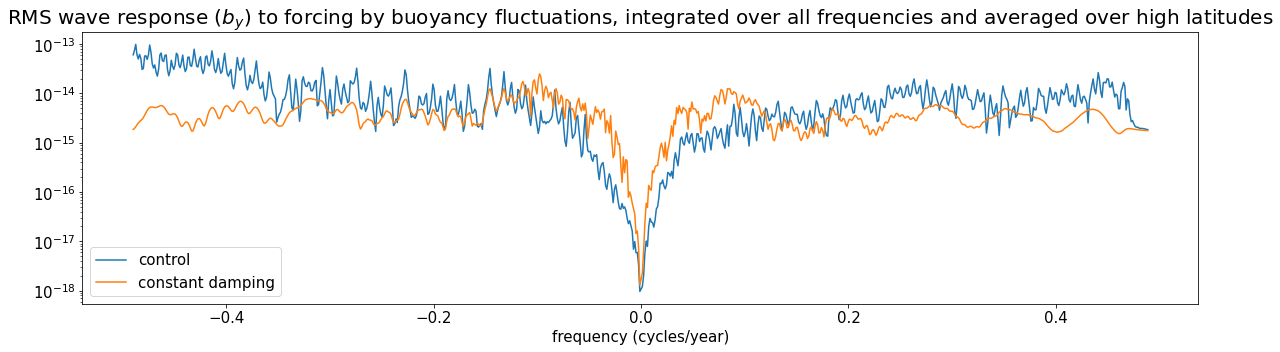

In [276]:
_,ax=plt.subplots(1,1,figsize=(20,5))
order=np.argsort(freqs)
ax.plot(freqs[order],ay_byfreq_sim[order]     ,label='control')
ax.plot(freqs[order],ay_byfreq_sim_fixA[order],label='constant damping')
#ax.axvline(-0.49)
#ax.axvline(0.4887)
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_title(r"RMS wave response ($b_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

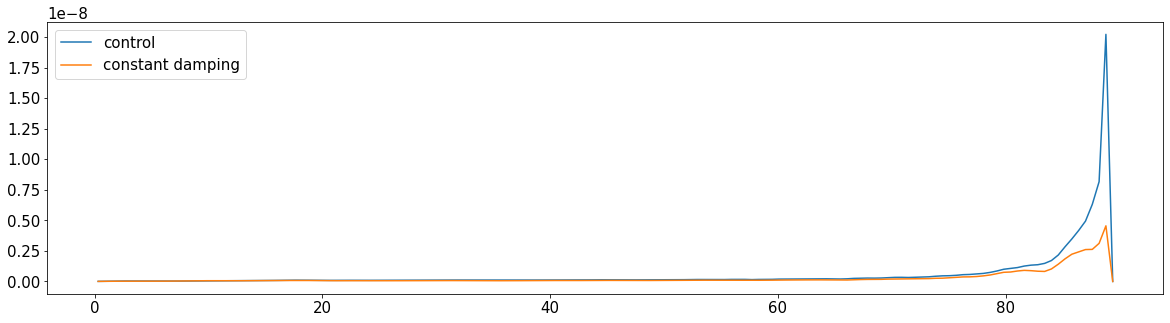

In [293]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_sim/1e3*sectoyear,label='control')
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_sim_fixA/1e3*sectoyear,label='constant damping')

ax.legend()

In [289]:
freqs,ay_byfreq_syn     ,by_byfreq_syn     ,ay_rms_syn     ,by_rms_syn      = forced_waves_rms_2(temperature_y_layer_tilda_150_NH,m,2,fixedparams,syntheticRHS=True)
freqs,ay_byfreq_syn_fixA,by_byfreq_syn_fixA,ay_rms_syn_fixA,by_rms_syn_fixA = forced_waves_rms_2(temperature_y_layer_tilda_150_NH,m,2,fixedparams,syntheticRHS=True,fixA=True)


Number of frequencies treated (500 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 Number of frequencies treated (500 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 

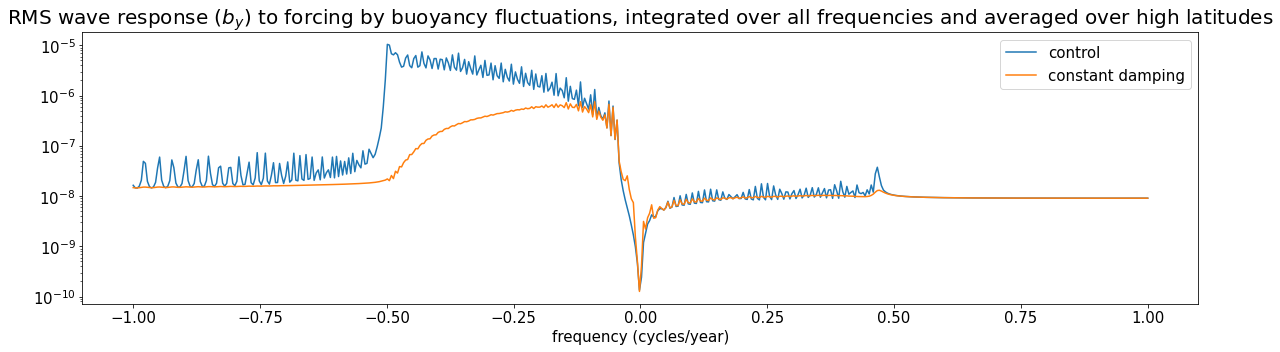

In [290]:
_,ax=plt.subplots(1,1,figsize=(20,5))
order=np.argsort(freqs)
ax.plot(freqs[order],ay_byfreq_syn[order]     ,label='control')
ax.plot(freqs[order],ay_byfreq_syn_fixA[order],label='constant damping')
#ax.axvline(-0.49)
#ax.axvline(0.4887)
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_title(r"RMS wave response ($b_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

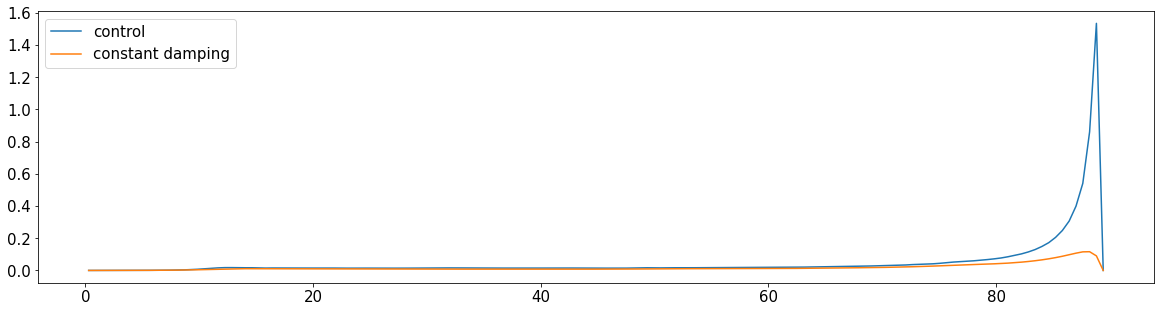

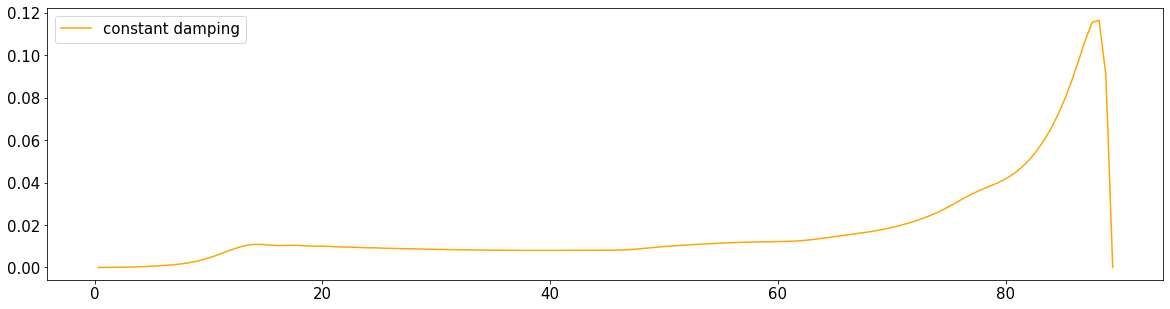

In [314]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_syn/1e3*sectoyear,label='control')
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_syn_fixA/1e3*sectoyear,label='constant damping')
ax.legend()
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_syn_fixA/1e3*sectoyear,label='constant damping',color='orange')
ax.legend()

In [322]:
freqs,ay_byfreq_syn     ,by_byfreq_syn     ,ay_rms_syn     ,by_rms_syn      = forced_waves_rms_2(temperature_y_layer_tilda_150_NH,m,2,fixedparams,syntheticRHS=True          ,frequencies=np.linspace(-0.1,-0.01,50))
freqs,ay_byfreq_syn_fixA,by_byfreq_syn_fixA,ay_rms_syn_fixA,by_rms_syn_fixA = forced_waves_rms_2(temperature_y_layer_tilda_150_NH,m,2,fixedparams,syntheticRHS=True,fixA=True,frequencies=np.linspace(-0.1,-0.01,50))


Number of frequencies treated (50 total):  0 20 40 Number of frequencies treated (50 total):  0 20 40 

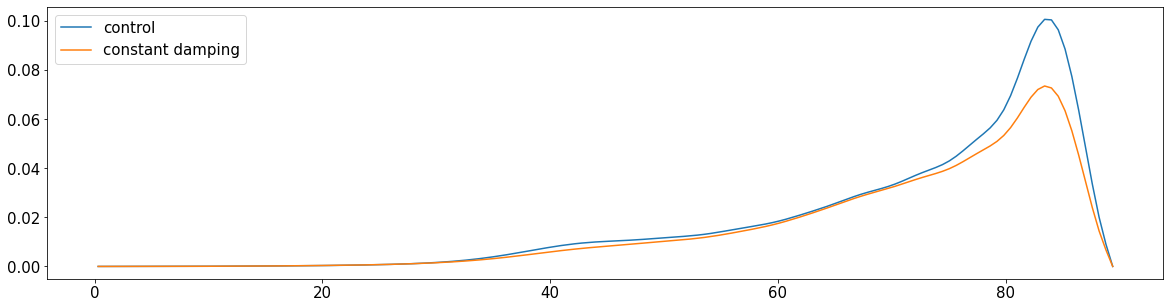

In [324]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_syn/1e3*sectoyear,label='control')
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_syn_fixA/1e3*sectoyear,label='constant damping')
ax.legend()

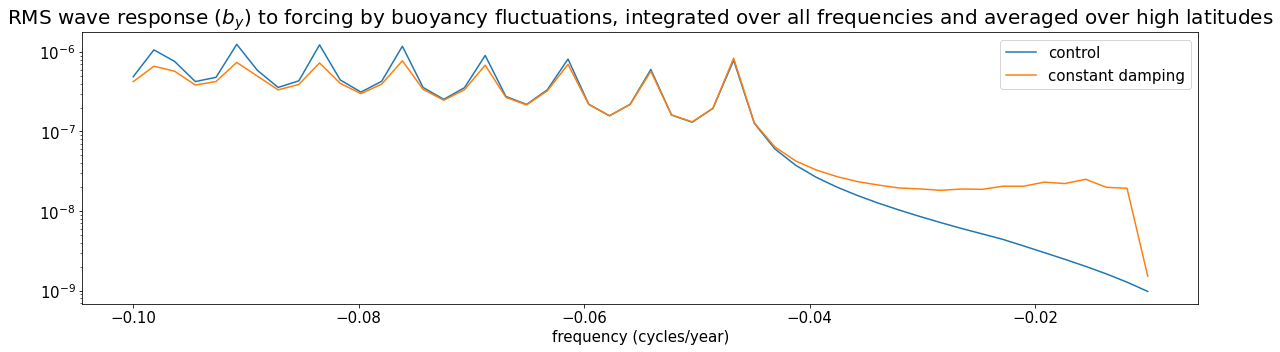

In [318]:
_,ax=plt.subplots(1,1,figsize=(20,5))
order=np.argsort(freqs)
ax.plot(freqs[order],ay_byfreq_syn[order]     ,label='control')
ax.plot(freqs[order],ay_byfreq_syn_fixA[order],label='constant damping')
#ax.axvline(-0.49)
#ax.axvline(0.4887)
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_title(r"RMS wave response ($b_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

## Power in RHS

In [310]:
def rhs_power(forcingtilda_r_NH,m,fixedparams):
    ones=np.ones((799, 58, 150))
    # Define freqs / radial wavenumbers
    E,Pm,_,Hprime,_,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    period = -20
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    C0 = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M0 = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Set up unforced problem
    ngrid = 150
    frequencies=nonzero_frequencies()
    y=set_y(ngrid)
    #Compute all forced waves
    Nf=len(frequencies)
    rhss=np.zeros((Nf,ngrid))*1j
    print("Number of frequencies treated (%i total): "%Nf,end=' ')
    for i,f in enumerate(frequencies):
        if i%20==0:
            print(i,end=' ')
        j=1
        period = 1/f
        kprime = np.pi*j/Hprime
        omegaprime = 2*np.pi / (period*sectoyear) / Omega
        C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
        
        chi = 1 +1j*kprime**2/omegaprime*E/Pm
        M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
        #rhs=set_buoyancy_forcing(forcingtilda_r_NH,period_to_freqindex(period),j,fixedparams)[0]
        rhs = set_rhs_forcing(y,C0,m,M,*set_buoyancy_forcing(forcingtilda_r_NH,period_to_freqindex(period),j,fixedparams))
        rhss[i]=rhs[150:]
    y=set_y(ngrid)[None,:]
    return frequencies,np.sqrt((np.abs(rhss)**2 * np.gradient(y,edge_order=2,axis=1)/(1-y**2) ).sum(axis=1))


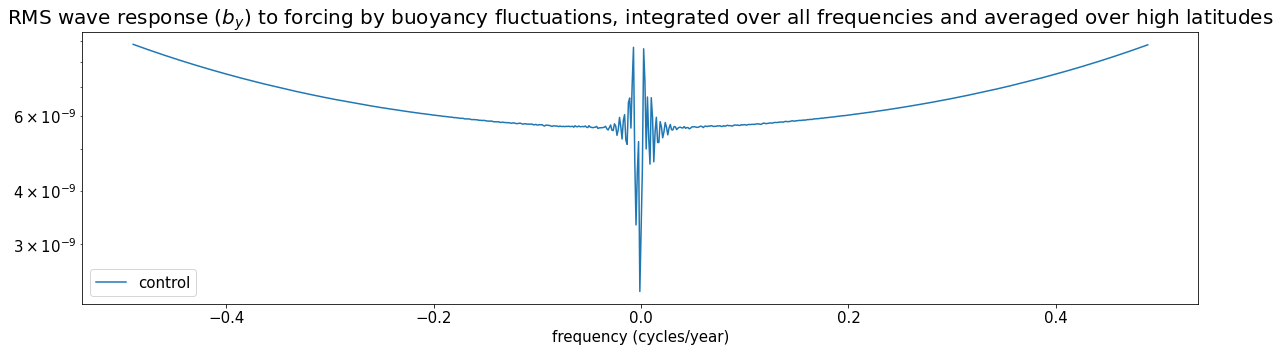

In [313]:
#freqs, rhsp = rhs_power(temperature_y_layer_tilda_150_NH,m,fixedparams)
_,ax=plt.subplots(1,1,figsize=(20,5))
order=np.argsort(freqs)
ax.plot(freqs[order],rhsp[order]*np.abs(freqs[order])     ,label='control')
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_title(r"RMS wave response ($b_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

# Response with sample forcings

In [48]:
# compute forced wave; two radius is enough to capture wave power to within less than a percent
%time _,_,psb1,_ = forced_waves_rms_fast("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,temperature_y_layer_tilda_150_SH,0.,0.,m,-1,1,fixedparams,300)
%time _,_,psb2,_ = forced_waves_rms_fast("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,temperature_y_layer_tilda_150_SH,0.,0.,m,-1,1,fixedparams,1)
%time _,_,psb3,_ = forced_waves_rms_fast("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,temperature_y_layer_tilda_150_SH,0.,0.,m,-1,1,fixedparams,5)
 

Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 24.6 s, sys: 1.53 s, total: 26.2 s
Wall time: 8.4 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 18 s, sys: 582 ms, total: 18.6 s
Wall time: 5.2 s


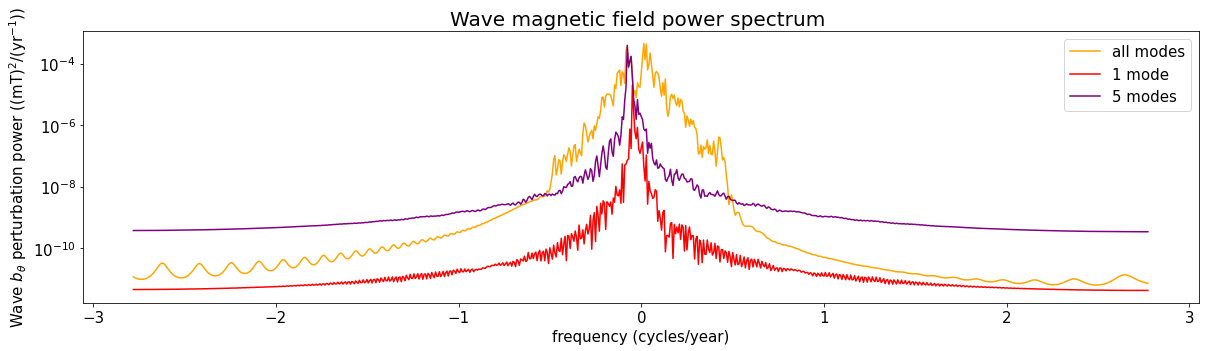

In [53]:
frequencies=nonzero_frequencies()
frequencies_sorted=np.sort(frequencies)

_,ax=plt.subplots(1,1,figsize=(20,5))

ax.plot(frequencies_sorted   ,psb1[np.argsort(frequencies)],color='orange',label=r'all modes')
ax.plot(frequencies_sorted   ,psb2[np.argsort(frequencies)],color='r',label=r'1 mode')
ax.plot(frequencies_sorted   ,psb3[np.argsort(frequencies)],color='purple',label=r'5 modes')

ax.legend(fontsize=15)
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave $b_\theta$ perturbation power ((mT)$^2$/(yr$^{-1}$))')
ax.set_title(r"Wave magnetic field power spectrum ",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')
#ax.set_xlim(-0.5,0.5)

In [3]:
# Compute C and M
ngrid = 150
C,M,chi = CMchi(fixedparams,-20,1)

# Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
y=set_y(ngrid)
A = set_A(ngrid,m,M)
wi,zi,xi=spl.eig(A,left=True)
#Normalize left eigenvectors so that zj^H * xi = delta_ij
zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
#Sort eigenvectors by increasing period
zi=zi[:,np.argsort(np.real(1/wi))]
xi=xi[:,np.argsort(np.real(1/wi))]
wi=wi[np.argsort(np.real(1/wi))]

In [7]:
# Power spectra, all modes and 1 modes, 2 different RHS

frequencies=nonzero_frequencies()
rhs11  = np.ones(300)
rhs01  = np.concatenate((np.zeros(150),np.ones(150)))

reps11 = np.zeros((150,799))*1j
reps01 = np.zeros((150,799))*1j
reps11_1mode = np.zeros((150,799))*1j
reps01_1mode = np.zeros((150,799))*1j

for freqindex in range(len(frequencies)):
    C1,_,_ = CMchi(fixedparams,freqindex_to_period(freqindex),1)
    reps11[:,freqindex]       =solve_forced_problem(y,A,C1,                   rhs11  )
    reps01[:,freqindex]       =solve_forced_problem(y,A,C1,                   rhs01  )
    reps11_1mode[:,freqindex] =solve_forced_problem_Nmodes_fast(y,xi,zi,wi,C1,rhs11,1)
    reps01_1mode[:,freqindex] =solve_forced_problem_Nmodes_fast(y,xi,zi,wi,C1,rhs01,1)

In [8]:
# Power spectra, sum squares / scalar products part, all modes

reps11_allmodes_sumsq = np.zeros(799)
reps01_allmodes_sumsq = np.zeros(799)

reps11_allmodes_sumsc = np.zeros(799)
reps01_allmodes_sumsc = np.zeros(799)

Gram_matrix = np.dot(xi[:150].conj().T/(1-y**2),xi[:150]/(1-y**2)[:,None])
np.fill_diagonal(Gram_matrix,0)

for freqindex in range(len(frequencies)):
    C1,_,_ = CMchi(fixedparams,freqindex_to_period(freqindex),1)
    reps11_allmodes_sumsq[freqindex] = (np.abs(np.dot(zi[:,:].conj().T,rhs11)/(wi[:]-C1) * xi[:150,:]/(1-y**2)[:,None] )**2).sum()
    reps01_allmodes_sumsq[freqindex] = (np.abs(np.dot(zi[:,:].conj().T,rhs01)/(wi[:]-C1) * xi[:150,:]/(1-y**2)[:,None] )**2).sum()

    reps11_allmodes_sumsc[freqindex] = np.real(np.sum( (np.dot(zi[:,:].conj().T,rhs11)/(wi[:]-C1)).conj()[:,None] * (np.dot(zi[:,:].conj().T,rhs11)/(wi[:]-C1))[None,:] * Gram_matrix )) 
    reps01_allmodes_sumsc[freqindex] = np.real(np.sum( (np.dot(zi[:,:].conj().T,rhs01)/(wi[:]-C1)).conj()[:,None] * (np.dot(zi[:,:].conj().T,rhs01)/(wi[:]-C1))[None,:] * Gram_matrix )) 

In [9]:
def plot_curve(rep,label,**plkwargs):
    freqs = np.sort(nonzero_frequencies())
    spectrum = (np.abs(rep)**2).sum(axis=0)[np.argsort(nonzero_frequencies())]
    plt.plot(freqs,spectrum,label=label+', slope=%.2f'%( (np.log(spectrum[100])-np.log(spectrum[0]))/(np.log(-freqs[100])-np.log(-freqs[0])) ),**plkwargs)
    
def power_slope(rep):
    freqs = np.sort(nonzero_frequencies())
    spectrum = (np.abs(rep)**2).sum(axis=0)[np.argsort(nonzero_frequencies())]
    return (np.log(spectrum[100])-np.log(spectrum[0]))/(np.log(-freqs[100])-np.log(-freqs[0]))



Text(0, 0.5, 'Wave amplitude (nondim)')

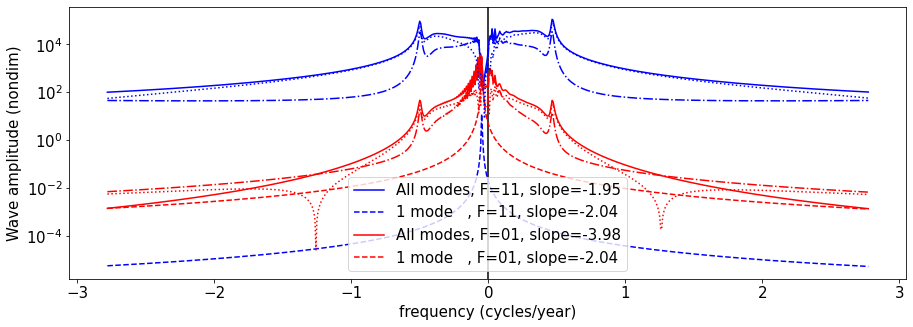

In [10]:
plt.figure(figsize=(15,5))
plt.axvline(0.,color='k')
plot_curve(reps11      ,label="All modes, F=11",color='b'               )
plot_curve(reps11_1mode,label="1 mode   , F=11",color='b',linestyle='--')
plot_curve(reps01      ,label="All modes, F=01",color='r'               )
plot_curve(reps01_1mode,label="1 mode   , F=01",color='r',linestyle='--')

plt.plot(np.sort(frequencies),reps11_allmodes_sumsq[np.argsort(frequencies)],color='b',linestyle='-.')
plt.plot(np.sort(frequencies),reps01_allmodes_sumsq[np.argsort(frequencies)],color='r',linestyle='-.')

plt.plot(np.sort(frequencies),np.abs(reps11_allmodes_sumsc[np.argsort(frequencies)]),color='b',linestyle=':')
plt.plot(np.sort(frequencies),np.abs(reps01_allmodes_sumsc[np.argsort(frequencies)]),color='r',linestyle=':')


plt.legend()
plt.yscale('log')
#plt.xlim(-0.5,0.5)
plt.xlabel("frequency (cycles/year)")
plt.ylabel("Wave amplitude (nondim)")

In [11]:
testCs=10**np.linspace(-2,5,1000)
A_sparse = sps.csc_matrix(A)
reps_all = [spl.norm(spsl.spsolve(A_sparse-c*sps.eye(2*ngrid),rhs01))**2 for c in testCs]
reps_f150 = [np.sum(np.abs(spsl.spsolve(A_sparse-c*sps.eye(2*ngrid),rhs01)[:150])**2) for c in testCs]

In [56]:
def C_to_frequency(fixedparams,c):
    _,_,_,Hprime,Nprime,_=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    kprime = np.pi/Hprime
    return c / ( 2/0.65**2*kprime**2/Nprime**2 * 2*np.pi / (sectoyear* Omega) )


Text(0, 0.5, 'Wave amplitude (nondim)')

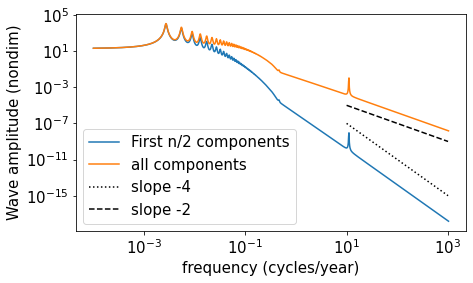

In [16]:
plt.figure(figsize=(7,4))
plt.plot(C_to_frequency(fixedparams,testCs),reps_f150,label="First n/2 components")
plt.plot(C_to_frequency(fixedparams,testCs),reps_all, label="all components")
plt.plot([10,1000],1e-7*np.array([1,1e-4])**2,color='k',linestyle=':',label='slope -4')
plt.plot([10,1000],1e-5*np.array([1,1e-4]),color='k',linestyle='--',label='slope -2')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.xlabel("frequency (cycles/year)")
plt.ylabel("Wave amplitude (nondim)")